### Import Libraries

In [1]:
# Pre Processing 
import pandas as pd
import datetime as dt
import numpy as np

# Exploratory Data
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import squarify 
%matplotlib inline

# Pandasql Environment
import pandas as pd
import pandasql

from pandasql import sqldf 
sql_run = lambda q: sqldf(q, globals())

### Load Bank Transaction Data

In [2]:
Data = pd.read_csv('bank_transactions.csv')
pd.set_option('display.max_columns', None)
Data

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053     10/1/94          F     JAMSHEDPUR   
1                  T2   C2142763      4/4/57          M        JHAJJAR   
2                  T3   C4417068    26/11/96          F         MUMBAI   
3                  T4   C5342380     14/9/73          F         MUMBAI   
4                  T5   C9031234     24/3/88          F    NAVI MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229      8/4/90          M      NEW DELHI   
1048563      T1048564   C6459278     20/2/92          M         NASHIK   
1048564      T1048565   C6412354     18/5/89          M      HYDERABAD   
1048565      T1048566   C6420483     30/8/78          M  VISAKHAPATNAM   
1048566      T1048567   C8337524      5/3/84          M           PUNE   

         CustAccountBalance TransactionDate  TransactionTime  \
0                  17819.05          2/8/16           143207   
1                   2270.69          2/8/16           141858   
2                  17874.44          2/8/16           142712   
3                 866503.21          2/8/16           142714   
4                   6714.43          2/8/16           181156   
...                     ...             ...              ...   
1048562             7635.19         18/9/16           184824   
1048563            27311.42         18/9/16           183734   
1048564           221757.06         18/9/16           183313   
1048565            10117.87         18/9/16           184706   
1048566            75734.42         18/9/16           181222   

         TransactionAmount (INR)  
0                           25.0  
1                        27999.0  
2                          459.0  
3                         2060.0  
4                         1762.5  
...                          ...  
1048562                    799.0  
1048563                    460.0  
1048564                    770.0  
1048565                   1000.0  
1048566                   1166.0  

[1048567 rows x 9 columns]

### Dataset Profiling

In [3]:
def dataset_profile(csv):
    print("Dataset dimension :", csv.ndim)
    print("Dataset shape :", csv.shape)
    print("Dataset size :", csv.size)

dataset_profile(Data)

Dataset dimension : 2
Dataset shape : (1048567, 9)
Dataset size : 9437103


In [4]:
def features_types(csv):
    types = csv.dtypes.reset_index()
    types.columns = ['Features','Data Type']
    return types

features_types(Data)

Features Data Type
0            TransactionID    object
1               CustomerID    object
2              CustomerDOB    object
3               CustGender    object
4             CustLocation    object
5       CustAccountBalance   float64
6          TransactionDate    object
7          TransactionTime     int64
8  TransactionAmount (INR)   float64

### Dataset Inspection

### Missing and Blank Values Checking

In [5]:
def dataset_inspections(csv):
    missing_data = csv.isnull().sum().reset_index()
    missing_data.columns = ['Features','Missing Values']
    blank_data = csv.apply(lambda x : x == '.').sum().reset_index()
    blank_data.columns = ['Features','Blank Values']
    merged_data = pd.merge(missing_data, blank_data, on=['Features'])
    merged_data['Filling Factor'] = (csv.shape[0]-missing_data['Missing Values'] + csv.shape[0]-blank_data['Blank Values'])/csv.shape[0]*50
    merged_data = merged_data.sort_values(by='Filling Factor',ascending=True)
    return merged_data

dataset_inspections(Data)

Features  Missing Values  Blank Values  Filling Factor
2              CustomerDOB            3397             0       99.838017
5       CustAccountBalance            2369             0       99.887036
3               CustGender            1100             0       99.947547
4             CustLocation             151            86       99.988699
0            TransactionID               0             0      100.000000
1               CustomerID               0             0      100.000000
6          TransactionDate               0             0      100.000000
7          TransactionTime               0             0      100.000000
8  TransactionAmount (INR)               0             0      100.000000

### Cross Checking Missing Values with ASSERT Statement

In [6]:
# Assert that there are no missing values in the dataframe

assert pd.notnull(Data).all().all()

AssertionError: 

Interpretation
 - The above command does indeed throw an error. Hence, it is confirmed that there are missing or negative values in the dataset
 - Some of the values within dataset either missing or negative.
 - Proceed to data cleaning

### Dataset Overview

In [7]:
def initial_eda(df):
    if isinstance(df, pd.DataFrame):
        total_na = df.isna().sum().sum()
        print("Dimensions : %d rows, %d columns" % (df.shape[0], df.shape[1]))
        print("Total NA Values : %d " % (total_na))
        print("%38s %10s     %10s %10s" % ("Column Name", "Data Type", "#Distinct", "NA Values"))
        col_name = df.columns
        dtyp = df.dtypes
        uniq = df.nunique()
        na_val = df.isna().sum()
        for i in range(len(df.columns)):
            print("%38s %10s   %10s %10s" % (col_name[i], dtyp[i], uniq[i], na_val[i]))
        
    else:
        print("Expect a DataFrame but got a %15s" % (type(df)))
        
initial_eda(Data)

Dimensions : 1048567 rows, 9 columns
Total NA Values : 7017 
                           Column Name  Data Type      #Distinct  NA Values
                         TransactionID     object      1048567          0
                            CustomerID     object       884265          0
                           CustomerDOB     object        17254       3397
                            CustGender     object            3       1100
                          CustLocation     object         9355        151
                    CustAccountBalance    float64       161328       2369
                       TransactionDate     object           55          0
                       TransactionTime      int64        81918          0
               TransactionAmount (INR)    float64        93024          0


### Categorical Features

In [8]:
categorical = [var for var in Data.columns if Data[var].dtype=='O']

print('There are {} categorical variables\n'.format(len(categorical)))

print('The categorical variables are :\n\n', categorical)

There are 6 categorical variables

The categorical variables are :

 ['TransactionID', 'CustomerID', 'CustomerDOB', 'CustGender', 'CustLocation', 'TransactionDate']


### Numerical Features

In [9]:
numericalint = [var for var in Data.columns if Data[var].dtype=='int64']
numericalfloat = [var for var in Data.columns if Data[var].dtype=='float64']
numerical = numericalint + numericalfloat

print('There are {} numerical variables\n'.format(len(numerical)))

print('The numerical variables are :\n\n', numerical)

There are 3 numerical variables

The numerical variables are :

 ['TransactionTime', 'CustAccountBalance', 'TransactionAmount (INR)']


### Categorical Features Distinc Value Distribution

In [10]:
for var in categorical: 
    jumlah1 = len(Data[var].unique())
    print(f'There are', jumlah1,'unique values in')
    print(f'Count of each values are:','\n', Data[var].value_counts(),'\n')

There are 1048567 unique values in
Count of each values are: 
 T1          1
T699051     1
T699038     1
T699039     1
T699040     1
           ..
T349528     1
T349529     1
T349530     1
T349531     1
T1048567    1
Name: TransactionID, Length: 1048567, dtype: int64 

There are 884265 unique values in
Count of each values are: 
 C5533885    6
C6624352    6
C1736254    6
C6735477    6
C1113684    6
           ..
C8716232    1
C4474828    1
C3341662    1
C6821983    1
C6420483    1
Name: CustomerID, Length: 884265, dtype: int64 

There are 17255 unique values in
Count of each values are: 
 1/1/1800    57339
1/1/89        809
1/1/90        784
6/8/91        699
1/1/91        666
            ...  
3/9/60          1
17/11/52        1
11/9/63         1
28/2/47         1
24/10/44        1
Name: CustomerDOB, Length: 17254, dtype: int64 

There are 4 unique values in
Count of each values are: 
 M    765530
F    281936
T         1
Name: CustGender, dtype: int64 

There are 9356 unique values in

### Categorical Values Abnormal Values Checking

In [11]:
for var in categorical: 
    print(Data[var].loc[Data[var].str.contains(',|%|@|!|#|`',na=False)])
    jumlah = Data[var].str.contains(',|%|@|!|#|&|`',na=False).sum()
    print('There are {} abnormal values\n'.format(jumlah))

Series([], Name: TransactionID, dtype: object)
There are 0 abnormal values

Series([], Name: CustomerID, dtype: object)
There are 0 abnormal values

Series([], Name: CustomerDOB, dtype: object)
There are 0 abnormal values

Series([], Name: CustGender, dtype: object)
There are 0 abnormal values

742        DOMBIVALI -WEST,THANE
3257        WHITEFIELD,BANGALORE
5322               JORHAT, ASSAM
6021           DIMAPUR, NAGALAND
6415             AIZAWL, MIZORAM
                   ...          
1022089          AIZAWL, MIZORAM
1028162       .-PURAM, BANGALORE
1037523        DIMAPUR, NAGALAND
1045258       .-PURAM, BANGALORE
1048251      BARPETA ROAD, ASSAM
Name: CustLocation, Length: 443, dtype: object
There are 443 abnormal values

Series([], Name: TransactionDate, dtype: object)
There are 0 abnormal values



### Data Cleaning : Handling Categorical Features Abnormal Values

In [12]:
# Dropping the abnormal Values
Data.drop(Data.loc[Data['CustLocation'].str.contains(',|%|@|!|#|&|`',na=False)].index, inplace=True)

# Replacing the dots to value which at most frequent for each feature
Data['CustLocation'] = Data['CustLocation'].replace(['.'],['MUMBAI'])
Data['CustomerDOB'] = Data['CustomerDOB'].replace(['1/1/1800'],['1/1/00'])
Data['CustGender'] = Data['CustGender'].replace(['T'],['M'])

### Features Missing Values Dropping

In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Dropping Missing Values
Data = Data.dropna(axis = 0, how ='any')
Data

TransactionID CustomerID CustomerDOB CustGender   CustLocation  \
0                  T1   C5841053     10/1/94          F     JAMSHEDPUR   
1                  T2   C2142763      4/4/57          M        JHAJJAR   
2                  T3   C4417068    26/11/96          F         MUMBAI   
3                  T4   C5342380     14/9/73          F         MUMBAI   
4                  T5   C9031234     24/3/88          F    NAVI MUMBAI   
...               ...        ...         ...        ...            ...   
1048562      T1048563   C8020229      8/4/90          M      NEW DELHI   
1048563      T1048564   C6459278     20/2/92          M         NASHIK   
1048564      T1048565   C6412354     18/5/89          M      HYDERABAD   
1048565      T1048566   C6420483     30/8/78          M  VISAKHAPATNAM   
1048566      T1048567   C8337524      5/3/84          M           PUNE   

         CustAccountBalance TransactionDate  TransactionTime  \
0                  17819.05          2/8/16           143207   
1                   2270.69          2/8/16           141858   
2                  17874.44          2/8/16           142712   
3                 866503.21          2/8/16           142714   
4                   6714.43          2/8/16           181156   
...                     ...             ...              ...   
1048562             7635.19         18/9/16           184824   
1048563            27311.42         18/9/16           183734   
1048564           221757.06         18/9/16           183313   
1048565            10117.87         18/9/16           184706   
1048566            75734.42         18/9/16           181222   

         TransactionAmount (INR)  
0                           25.0  
1                        27999.0  
2                          459.0  
3                         2060.0  
4                         1762.5  
...                          ...  
1048562                    799.0  
1048563                    460.0  
1048564                    770.0  
1048565                   1000.0  
1048566                   1166.0  

[1041171 rows x 9 columns]

### Cross Checking For Missing Values in Dataset

In [14]:
# Assert that there are no missing values in the dataframe
assert pd.notnull(Data).all().all()
initial_eda(Data)

Dimensions : 1041171 rows, 9 columns
Total NA Values : 0 
                           Column Name  Data Type      #Distinct  NA Values
                         TransactionID     object      1041171          0
                            CustomerID     object       879048          0
                           CustomerDOB     object        17232          0
                            CustGender     object            2          0
                          CustLocation     object         9246          0
                    CustAccountBalance    float64       160629          0
                       TransactionDate     object           55          0
                       TransactionTime      int64        81852          0
               TransactionAmount (INR)    float64        92359          0


### Re; Categorical Features Distinc Value Distribution Cross Check

In [ ]:
for var in categorical: 
    jumlah1 = len(Data[var].unique())
    print(f'There are', jumlah1,'unique values in')
    print(f'Count of each values are:','\n', Data[var].value_counts(),'\n')

### Re; Categorical Values Abnormal Values Cross Check

In [ ]:
for var in categorical: 
    print(Data[var].loc[Data[var].str.contains(',|%|@|!|#|`',na=False)])
    jumlah = Data[var].str.contains(',|%|@|!|#|&|`',na=False).sum()
    print('There are {} abnormal values\n'.format(jumlah))

### Feature Engineering

### `Age` Feature

In [15]:
# Change to date type feature
Data['CustomerDOB'] = pd.to_datetime(Data['CustomerDOB'], format = '%d/%m/%y')
Data['Age'] = 2022 - (pd.DatetimeIndex(Data['CustomerDOB']).year)
Data = Data.loc[Data['Age'] > 0]
Data.drop('CustomerDOB',axis=1,inplace=True)
pd.DataFrame(Data['Age'])

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\2237952636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['CustomerDOB'] = pd.to_datetime(Data['CustomerDOB'], format = '%d/%m/%y')
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\2237952636.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Age'] = 2022 - (pd.DatetimeIndex(Data['CustomerDOB']).year)
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\2237952636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

Age
0         28
2         26
3         49
4         34
5         50
...      ...
1048562   32
1048563   30
1048564   33
1048565   44
1048566   38

[987066 rows x 1 columns]

### `Frequency` Feature

In [16]:
# Renaming Transaction times to Frequency
Data.rename(columns = {'TransactionTime':'Frequency'}, inplace = True)
pd.DataFrame(Data['Frequency'])

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\2299100543.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data.rename(columns = {'TransactionTime':'Frequency'}, inplace = True)


Frequency
0           143207
2           142712
3           142714
4           181156
5           173940
...            ...
1048562     184824
1048563     183734
1048564     183313
1048565     184706
1048566     181222

[987066 rows x 1 columns]

### `Monetary` Feature 

In [17]:
Data['Monetary'] = Data['Frequency']* Data['TransactionAmount (INR)']
pd.DataFrame(Data['Monetary'])

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\3979922019.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Monetary'] = Data['Frequency']* Data['TransactionAmount (INR)']


Monetary
0          3580175.0
2         65504808.0
3        293990840.0
4        319287450.0
5        117583440.0
...              ...
1048562  147674376.0
1048563   84517640.0
1048564  141151010.0
1048565  184706000.0
1048566  211304852.0

[987066 rows x 1 columns]

### `Recency` Feature

In [18]:
Data['TransactionDate'] = pd.to_datetime(Data['TransactionDate'], format = '%d/%m/%y')
Data['Recency'] = max(Data['TransactionDate']) - Data['TransactionDate']
Data['Recency'] = Data['Recency'].dt.days
pd.DataFrame(Data['Recency'])

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\4171326575.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['TransactionDate'] = pd.to_datetime(Data['TransactionDate'], format = '%d/%m/%y')
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\4171326575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data['Recency'] = max(Data['TransactionDate']) - Data['TransactionDate']
C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_3108\4171326575.py:3: SettingWithCopyWarning: 
A value is trying to be set 

Recency
0             80
2             80
3             80
4             80
5             80
...          ...
1048562       33
1048563       33
1048564       33
1048565       33
1048566       33

[987066 rows x 1 columns]

In [19]:
Data

TransactionID CustomerID CustGender   CustLocation  \
0                  T1   C5841053          F     JAMSHEDPUR   
2                  T3   C4417068          F         MUMBAI   
3                  T4   C5342380          F         MUMBAI   
4                  T5   C9031234          F    NAVI MUMBAI   
5                  T6   C1536588          F       ITANAGAR   
...               ...        ...        ...            ...   
1048562      T1048563   C8020229          M      NEW DELHI   
1048563      T1048564   C6459278          M         NASHIK   
1048564      T1048565   C6412354          M      HYDERABAD   
1048565      T1048566   C6420483          M  VISAKHAPATNAM   
1048566      T1048567   C8337524          M           PUNE   

         CustAccountBalance TransactionDate  Frequency  \
0                  17819.05      2016-08-02     143207   
2                  17874.44      2016-08-02     142712   
3                 866503.21      2016-08-02     142714   
4                   6714.43      2016-08-02     181156   
5                  53609.20      2016-08-02     173940   
...                     ...             ...        ...   
1048562             7635.19      2016-09-18     184824   
1048563            27311.42      2016-09-18     183734   
1048564           221757.06      2016-09-18     183313   
1048565            10117.87      2016-09-18     184706   
1048566            75734.42      2016-09-18     181222   

         TransactionAmount (INR)  Age     Monetary  Recency  
0                           25.0   28    3580175.0       80  
2                          459.0   26   65504808.0       80  
3                         2060.0   49  293990840.0       80  
4                         1762.5   34  319287450.0       80  
5                          676.0   50  117583440.0       80  
...                          ...  ...          ...      ...  
1048562                    799.0   32  147674376.0       33  
1048563                    460.0   30   84517640.0       33  
1048564                    770.0   33  141151010.0       33  
1048565                   1000.0   44  184706000.0       33  
1048566                   1166.0   38  211304852.0       33  

[987066 rows x 11 columns]

### Descriptive Statistics

In [20]:
Data.describe()

CustAccountBalance      Frequency  TransactionAmount (INR)  \
count        9.870660e+05  987066.000000             9.870660e+05   
mean         9.801043e+04  157291.952912             1.480862e+03   
std          5.326166e+05   51453.507505             6.307489e+03   
min          0.000000e+00       0.000000             0.000000e+00   
25%          4.526533e+03  124133.000000             1.540000e+02   
50%          1.593774e+04  164500.000000             4.360000e+02   
75%          5.360340e+04  200210.000000             1.134000e+03   
max          6.138221e+07  235959.000000             1.560035e+06   

                 Age      Monetary        Recency  
count  987066.000000  9.870660e+05  987066.000000  
mean       34.776493  2.358410e+08      56.805642  
std         6.741188  1.053047e+09      15.154135  
min         1.000000  0.000000e+00       0.000000  
25%        30.000000  2.052500e+07      45.000000  
50%        34.000000  6.422477e+07      57.000000  
75%        39.000000  1.840340e+08      70.000000  
max        53.000000  2.827654e+11      81.000000

### Correlation

In [21]:
# plot correlation heatmap to find out correlations

Data.corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

### Exploratory Data Analysis

### Numerical Features Distribution

C:\Users\GIGABYTE\anaconda3\envs\GIGABYTE\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\GIGABYTE\anaconda3\envs\GIGABYTE\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\GIGABYTE\anaconda3\envs\GIGABYTE\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function w

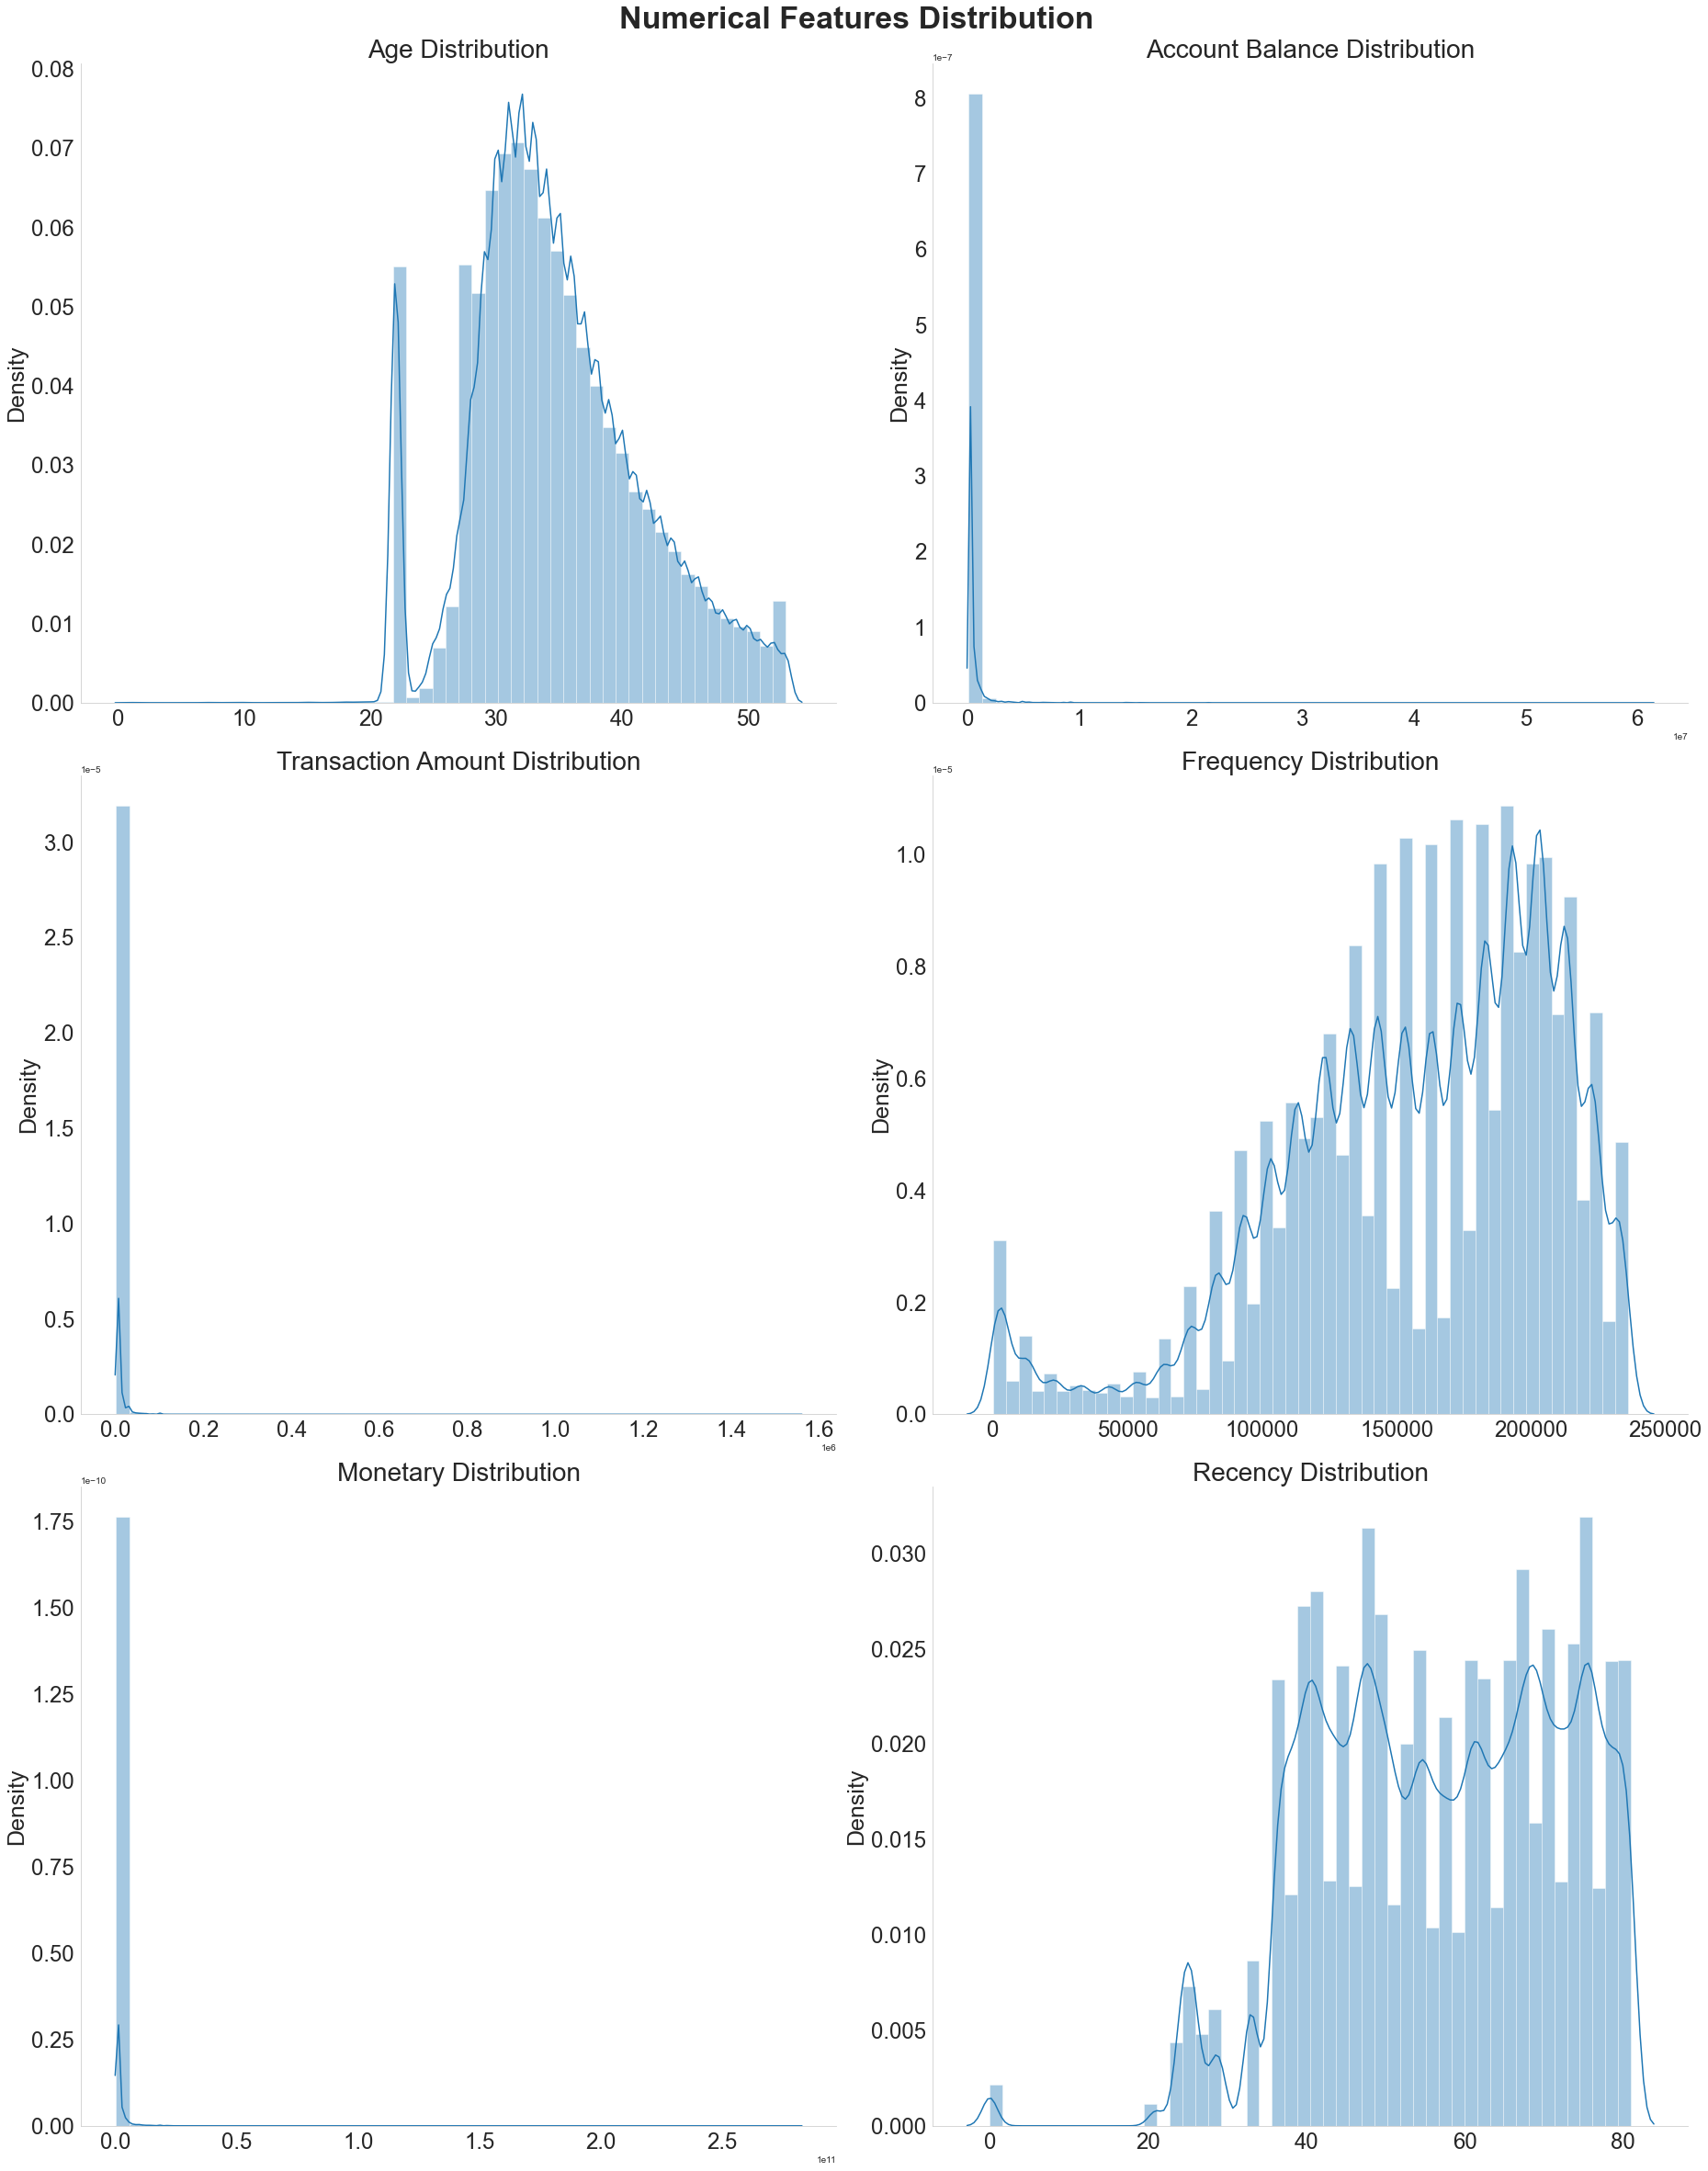

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(26,33))
fig.suptitle("Numerical Features Distribution", fontsize=34,fontweight='bold', verticalalignment="bottom")

#Plot 1
plt.subplot(3,2,1)
ax1 = sns.distplot(x = Data['Age'], kde = True, ax=ax1)
ax1.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_title('Age Distribution',fontsize=28, fontweight='normal')

# Plot 2
plt.subplot(3,2,2)
ax2 = sns.distplot(x = Data['CustAccountBalance'], kde = True, ax=ax2)
ax2.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_title('Account Balance Distribution',fontsize=28, fontweight='normal')

# Plot 3
plt.subplot(3,2,3)
ax3 = sns.distplot(x = Data['TransactionAmount (INR)'], kde = True, ax=ax3)
ax3.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_title('Transaction Amount Distribution',fontsize=28, fontweight='normal')

# Plot 4
plt.subplot(3,2,4)
ax4 = sns.distplot(x = Data['Frequency'], kde = True, ax=ax4)
ax4.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_title('Frequency Distribution',fontsize=28, fontweight='normal')

# PLot 5
plt.subplot(3,2,5)
ax5 = sns.distplot(x = Data['Monetary'], kde = True, ax=ax5)
ax5.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_title('Monetary Distribution',fontsize=28, fontweight='normal')

# PLot 6
plt.subplot(3,2,6)
ax6 = sns.distplot(x = Data['Recency'], kde = True, ax=ax6)
ax6.set_ylabel('Density',fontsize=25,fontweight='normal')    
plt.xticks( fontsize=24)
plt.yticks( fontsize=24)
ax6.spines['right'].set_visible(False)
ax6.spines['top'].set_visible(False)
ax6.set_title('Recency Distribution',fontsize=28, fontweight='normal')

plt.tight_layout()

### `Customers Location` Feature

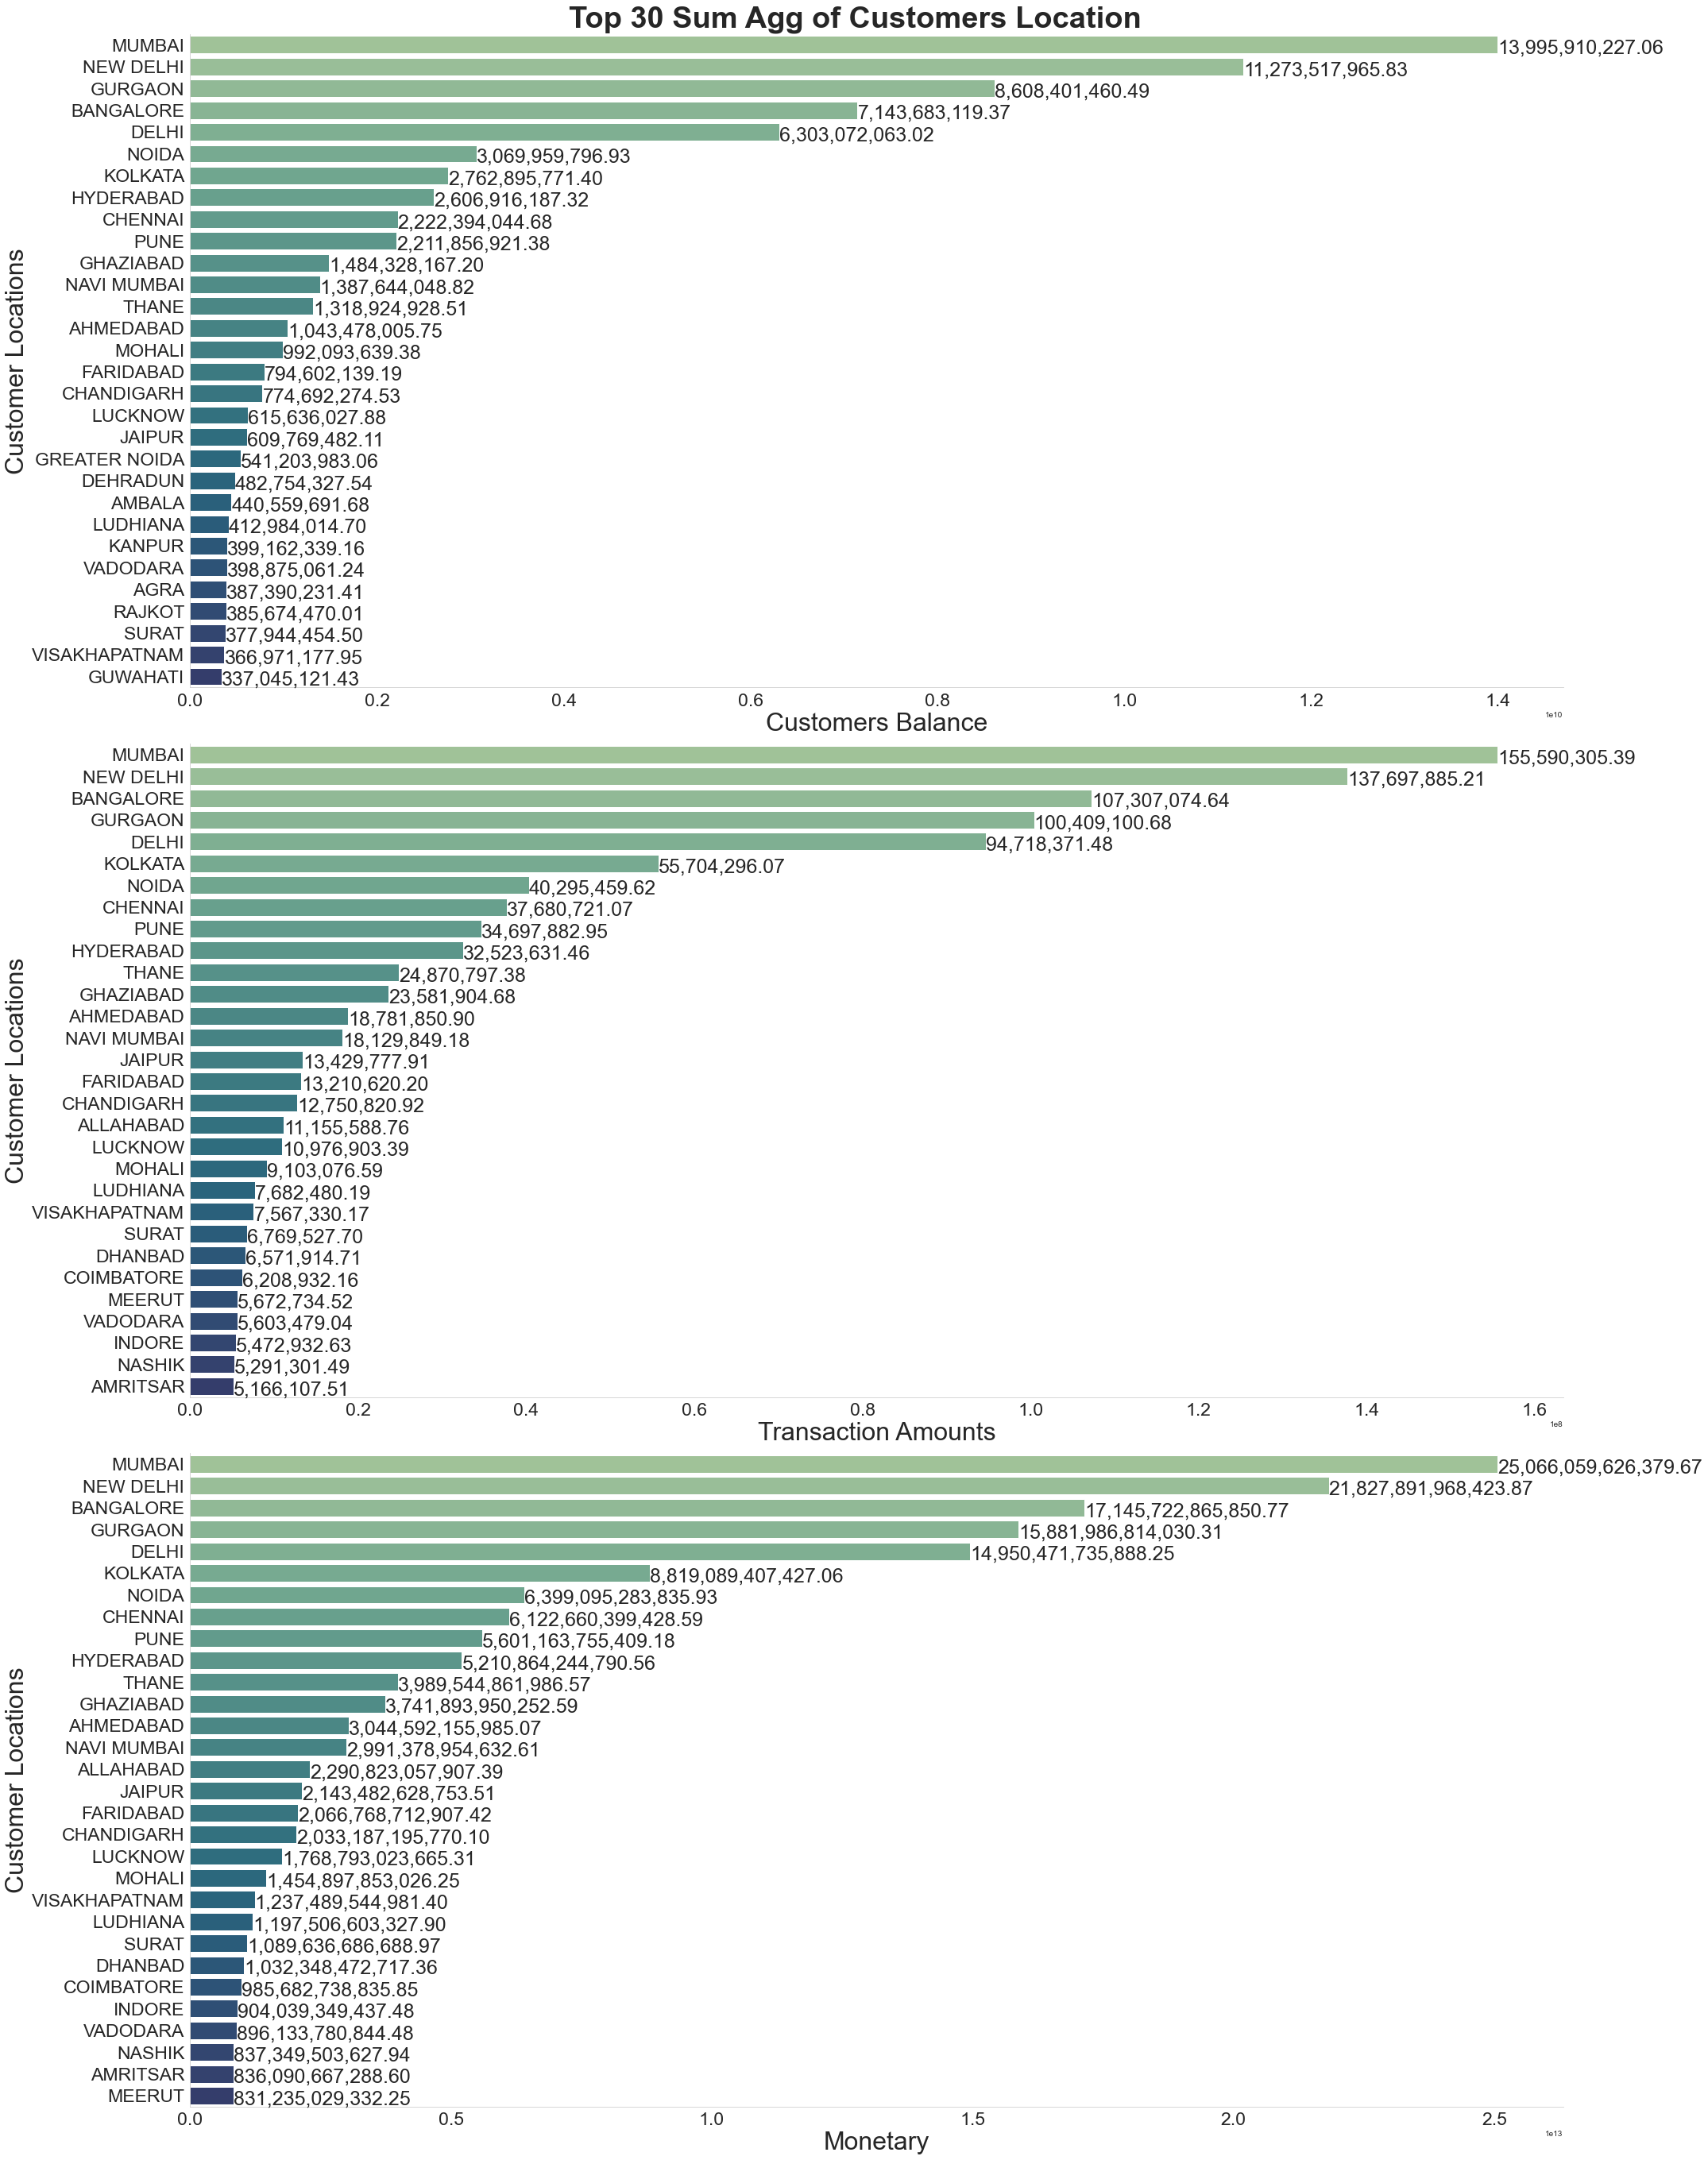

In [65]:
fig, (ax7, ax8, ax9) = plt.subplots(3,1,figsize=(30,38))
fig.suptitle("Top 30 Sum Agg of Customers Location", fontsize=38,fontweight='bold', verticalalignment="bottom")

#Plot 1
Data_cust2 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['CustAccountBalance'].sum())
Data_cust2 = Data_cust2.sort_values(by='CustAccountBalance', ascending=False)[:30]

plt.subplot(3,1,1)
ax7 = sns.barplot(x='CustAccountBalance', y='CustLocation',ax=ax7, data=Data_cust2,
                 palette=(sns.color_palette("crest", n_colors=30, desat=1)))
y7 = Data_cust2['CustAccountBalance']
for i, v in enumerate(y7):
    ax7.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax7.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax7.set_xlabel('Customers Balance',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax7.spines['right'].set_visible(False)
ax7.spines['top'].set_visible(False)

#Plot 2
Data_cust3 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['TransactionAmount (INR)'].sum())
Data_cust3 = Data_cust3.sort_values(by='TransactionAmount (INR)', ascending=False)[:30]

plt.subplot(3,1,2)
a8 = sns.barplot(x='TransactionAmount (INR)', y='CustLocation',ax=ax8, data=Data_cust3,
                palette=(sns.color_palette("crest", n_colors=30, desat=1)))
y8 = Data_cust3['TransactionAmount (INR)']
for i, v in enumerate(y8):
    ax8.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax8.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax8.set_xlabel('Transaction Amounts',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax8.spines['right'].set_visible(False)
ax8.spines['top'].set_visible(False)

#Plot 3
Data_cust5 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['Monetary'].sum())
Data_cust5 = Data_cust5.sort_values(by='Monetary', ascending=False)[:30]

plt.subplot(3,1,3)
ax9 = sns.barplot(x='Monetary', y='CustLocation',ax=ax9, data=Data_cust5,
                 palette=(sns.color_palette("crest", n_colors=30, desat=1)))
y9 = Data_cust5['Monetary']
for i, v in enumerate(y9):
    ax9.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax9.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax9.set_xlabel('Monetary',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)

plt.tight_layout()

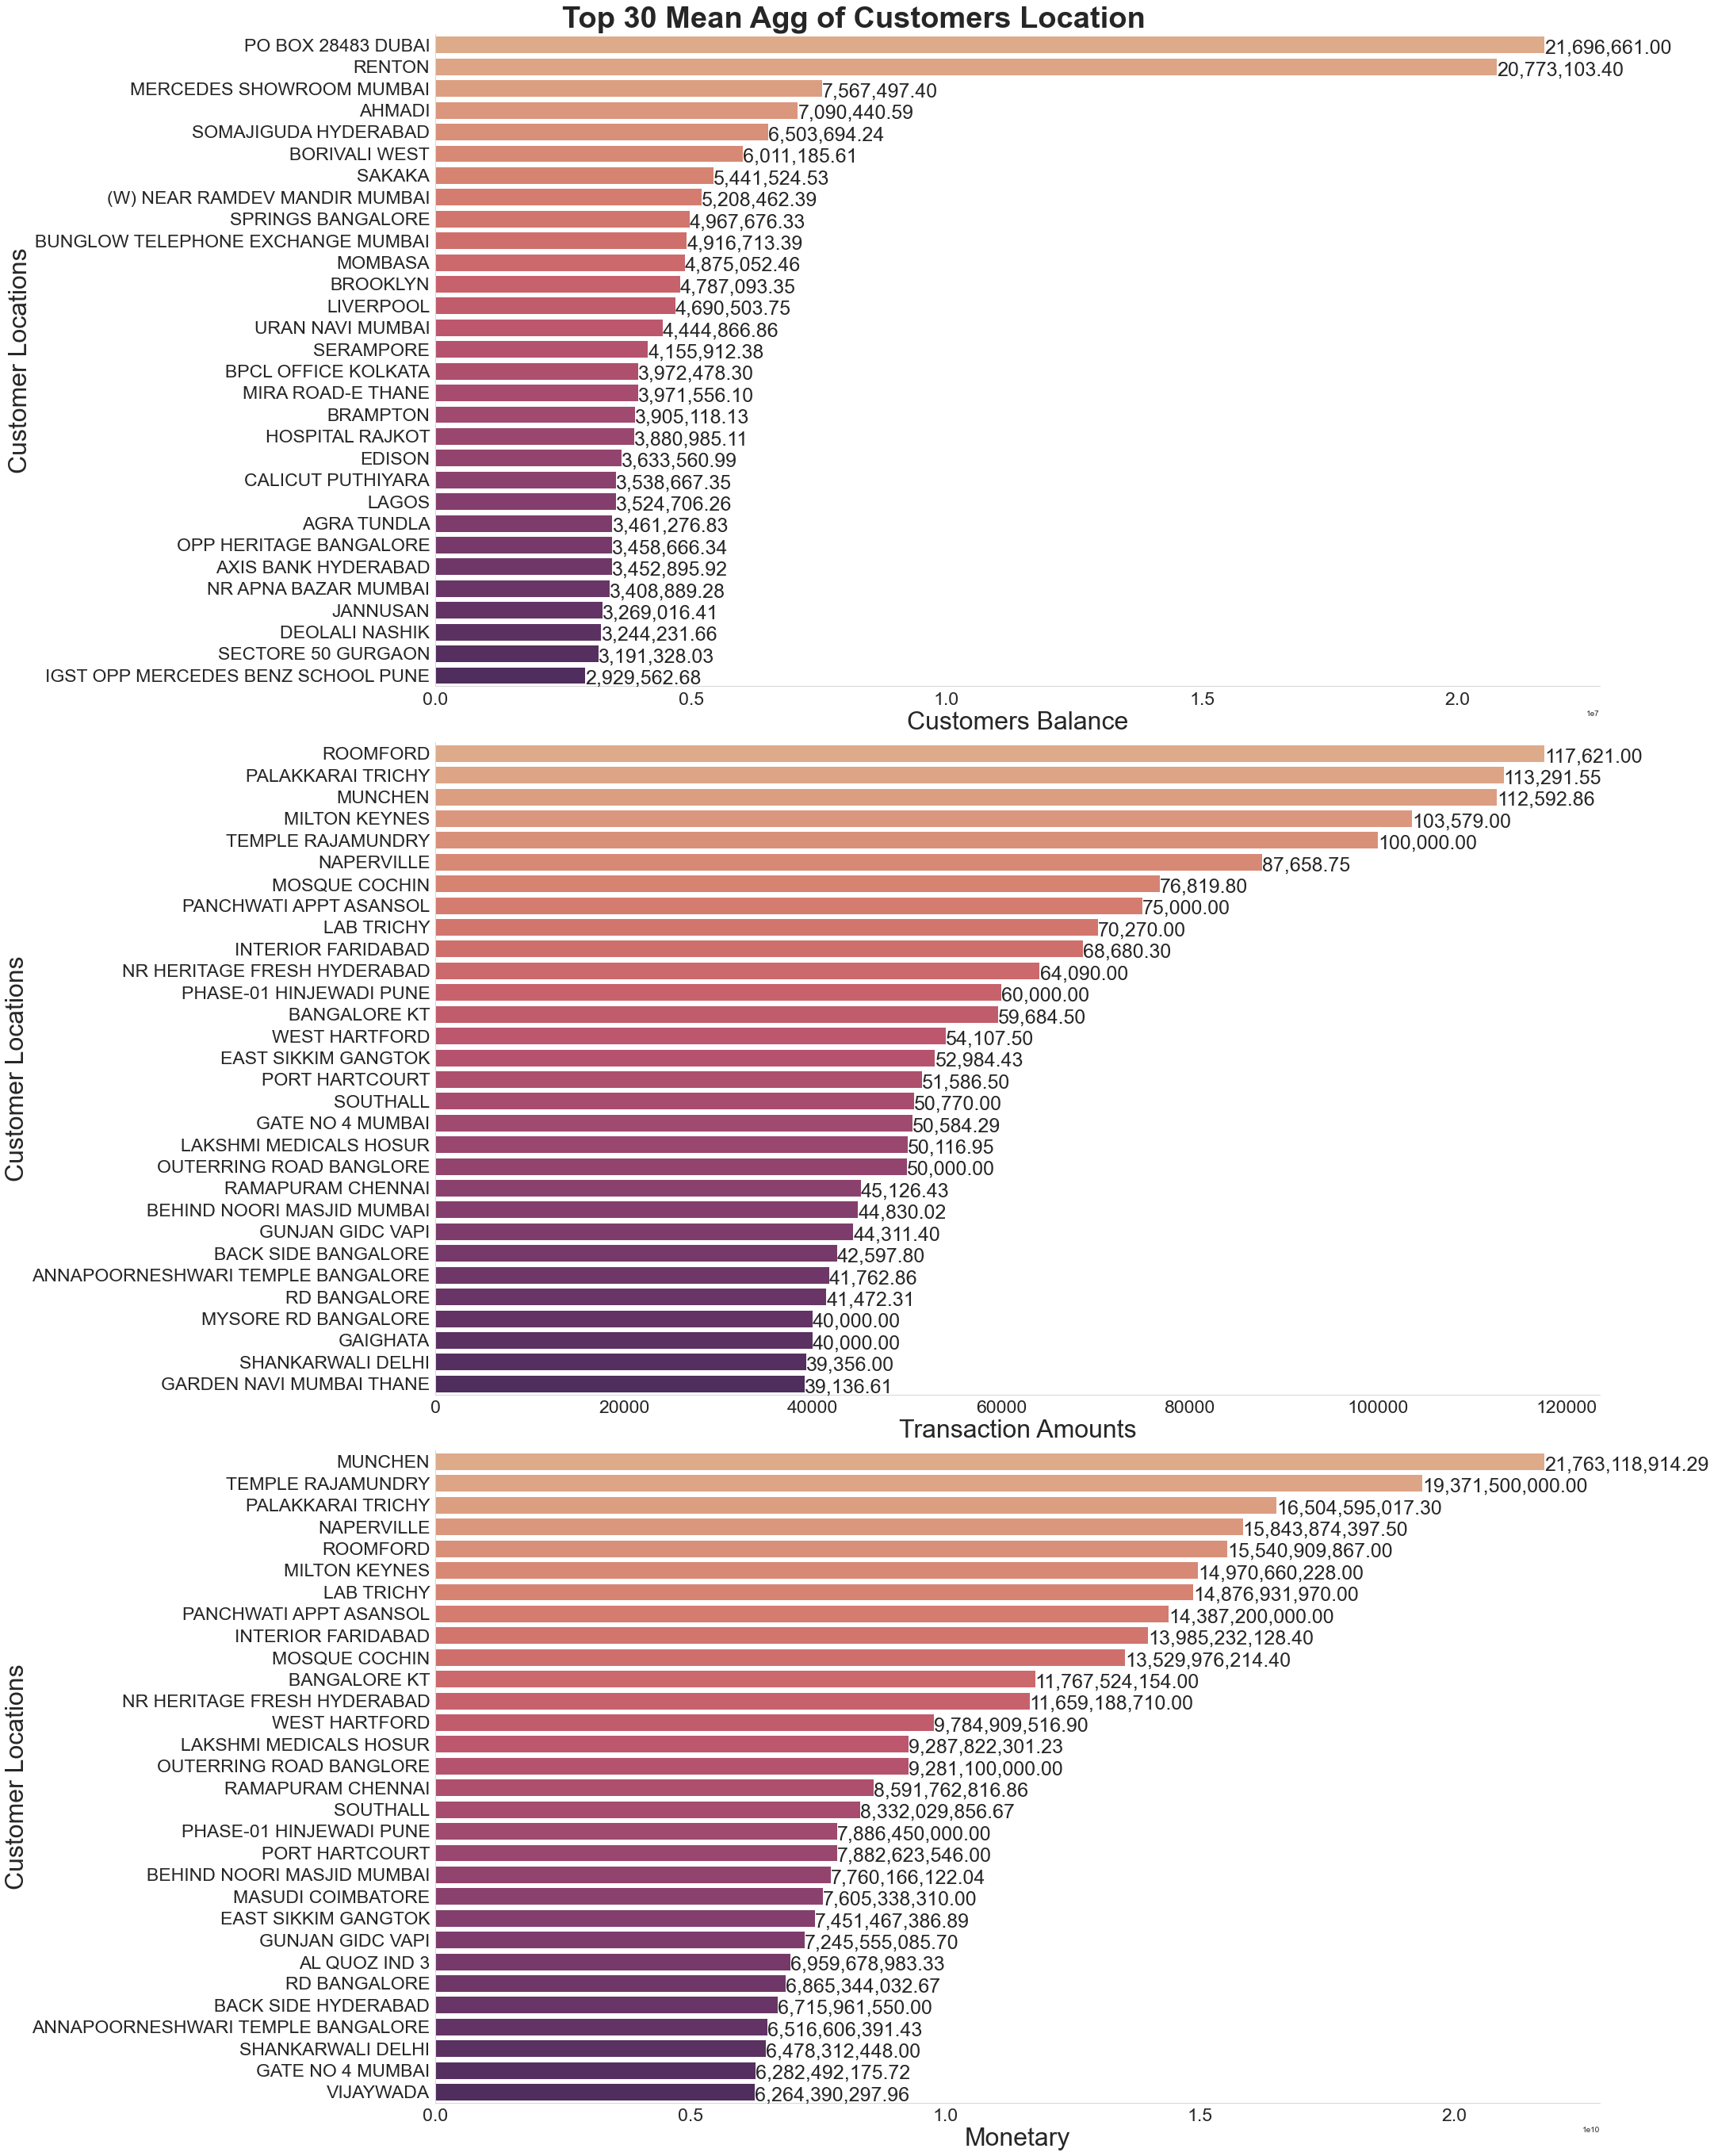

In [68]:
fig, (ax10, ax11, ax12) = plt.subplots(3,1,figsize=(30,38))
fig.suptitle("Top 30 Mean Agg of Customers Location", fontsize=38,fontweight='bold', verticalalignment="bottom")

#Plot 1
Data_cust6 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['CustAccountBalance'].mean())
Data_cust6 = Data_cust6.sort_values(by='CustAccountBalance', ascending=False)[:30]

plt.subplot(3,1,1)
ax10 = sns.barplot(x='CustAccountBalance', y='CustLocation',ax=ax10, data=Data_cust6,
                  palette=(sns.color_palette("flare", n_colors=30, desat=1)))
y10 = Data_cust6['CustAccountBalance']
for i, v in enumerate(y10):
    ax10.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax10.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax10.set_xlabel('Customers Balance',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)

#Plot 2
Data_cust7 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['TransactionAmount (INR)'].mean())
Data_cust7 = Data_cust7.sort_values(by='TransactionAmount (INR)', ascending=False)[:30]

plt.subplot(3,1,2)
ax11 = sns.barplot(x='TransactionAmount (INR)', y='CustLocation',ax=ax11, data=Data_cust7,
                  palette=(sns.color_palette("flare", n_colors=30, desat=1)))
y11 = Data_cust7['TransactionAmount (INR)']
for i, v in enumerate(y11):
    ax11.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax11.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax11.set_xlabel('Transaction Amounts',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax11.spines['right'].set_visible(False)
ax11.spines['top'].set_visible(False)

#Plot 3
Data_cust8 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['Monetary'].mean())
Data_cust8 = Data_cust8.sort_values(by='Monetary', ascending=False)[:30]

plt.subplot(3,1,3)
ax12 = sns.barplot(x='Monetary', y='CustLocation',ax=ax12, data=Data_cust8,
                  palette=(sns.color_palette("flare", n_colors=30, desat=1)))
y12 = Data_cust8['Monetary']
for i, v in enumerate(y12):
    ax12.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax12.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax12.set_xlabel('Monetary',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)

plt.tight_layout()

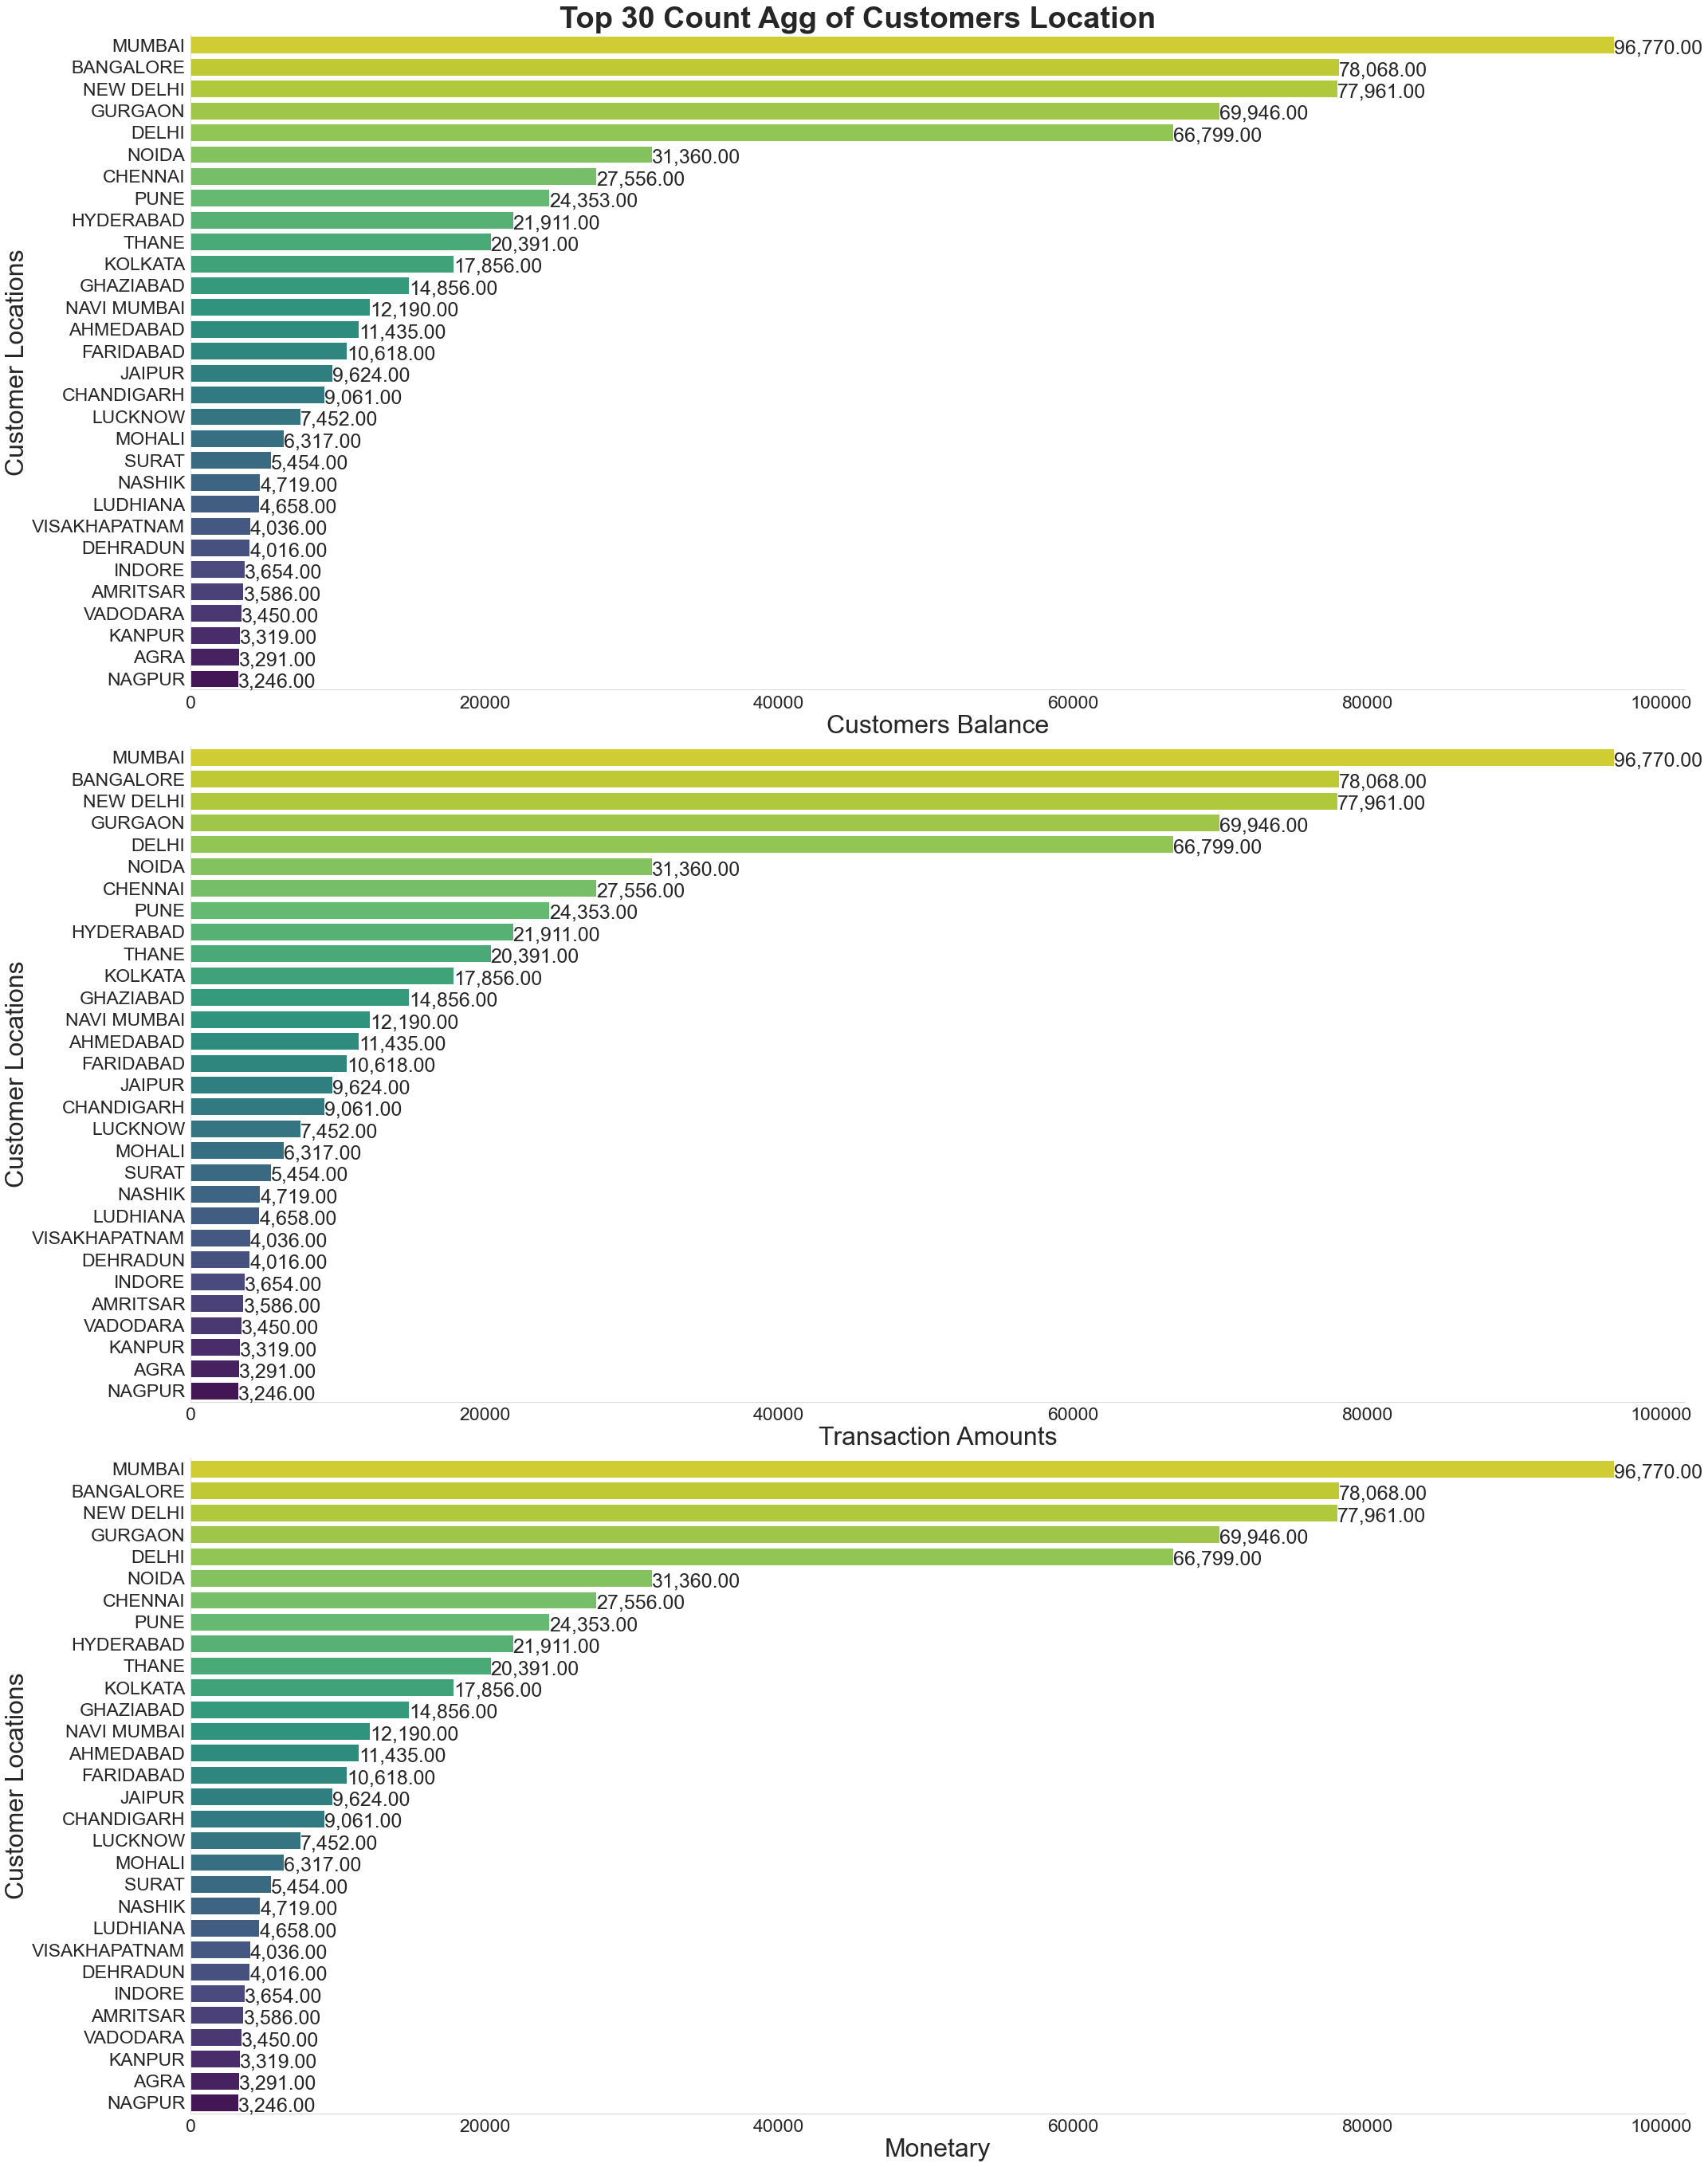

In [79]:
fig, (ax13, ax14, ax15) = plt.subplots(3,1,figsize=(30,38))
fig.suptitle("Top 30 Count Agg of Customers Location", fontsize=38,fontweight='bold', verticalalignment="bottom")

#Plot 1
Data_cust9 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['CustAccountBalance'].count())
Data_cust9 = Data_cust9.sort_values(by='CustAccountBalance', ascending=False)[:30]

plt.subplot(3,1,1)
ax13 = sns.barplot(x='CustAccountBalance', y='CustLocation',ax=ax13, data=Data_cust9,
                  palette=reversed(sns.color_palette("viridis", n_colors=30, desat=1)))
y13 = Data_cust9['CustAccountBalance']
for i, v in enumerate(y13):
    ax13.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax13.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax13.set_xlabel('Customers Balance',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax13.spines['right'].set_visible(False)
ax13.spines['top'].set_visible(False)

#Plot 2
Data_cust10 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['TransactionAmount (INR)'].count())
Data_cust10 = Data_cust10.sort_values(by='TransactionAmount (INR)', ascending=False)[:30]

plt.subplot(3,1,2)
ax14 = sns.barplot(x='TransactionAmount (INR)', y='CustLocation',ax=ax14, data=Data_cust10,
                  palette=reversed(sns.color_palette("viridis", n_colors=30, desat=1)))
y14 = Data_cust10['TransactionAmount (INR)']
for i, v in enumerate(y14):
    ax14.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax14.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax14.set_xlabel('Transaction Amounts',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax14.spines['right'].set_visible(False)
ax14.spines['top'].set_visible(False)

#Plot 3
Data_cust11 = pd.DataFrame(Data.groupby('CustLocation', as_index=False)['Monetary'].count())
Data_cust11 = Data_cust11.sort_values(by='Monetary', ascending=False)[:30]

plt.subplot(3,1,3)
ax15 = sns.barplot(x='Monetary', y='CustLocation',ax=ax15, data=Data_cust11,
                  palette=reversed(sns.color_palette("viridis", n_colors=30, desat=1)))
y15 = Data_cust11['Monetary']
for i, v in enumerate(y15):
    ax15.text(v+5, i+0.4, '{:,.2f}' .format(v),size=25)
ax15.set_ylabel('Customer Locations',fontsize=32,fontweight='normal')    
ax15.set_xlabel('Monetary',fontsize=32,fontweight='normal') 
plt.xticks( fontsize=23)
plt.yticks( fontsize=23)
ax15.spines['right'].set_visible(False)
ax15.spines['top'].set_visible(False)

plt.tight_layout()

### Filtering of Top 30 Sum Agg locations with SQL

In [84]:
query100 = """
SELECT DISTINCT CustLocation
FROM Data
WHERE CustLocation IN (SELECT CustLocation FROM Data_cust2 ) AND
CustLocation IN (SELECT CustLocation FROM Data_cust3) AND
CustLocation IN (SELECT CustLocation FROM Data_cust5)
ORDER BY 1 
"""

sumagg = sql_run(query100)
print(list(sumagg['CustLocation']))

['AHMEDABAD', 'BANGALORE', 'CHANDIGARH', 'CHENNAI', 'DELHI', 'FARIDABAD', 'GHAZIABAD', 'GURGAON', 'HYDERABAD', 'JAIPUR', 'KOLKATA', 'LUCKNOW', 'LUDHIANA', 'MOHALI', 'MUMBAI', 'NAVI MUMBAI', 'NEW DELHI', 'NOIDA', 'PUNE', 'SURAT', 'THANE', 'VADODARA', 'VISAKHAPATNAM']


### Filtering of Top 30 Mean Agg locations with SQL

In [88]:
query101 = """
SELECT DISTINCT CustLocation
FROM Data
WHERE CustLocation IN (SELECT CustLocation FROM Data_cust6) AND
CustLocation IN (SELECT CustLocation FROM Data_cust7) AND
CustLocation IN (SELECT CustLocation FROM Data_cust8)
ORDER BY 1 
"""

avgagg = sql_run(query101)
print(list(avgagg['CustLocation']))

[]


### Filtering of Top 30 Sum Count locations with SQL

In [87]:
query102 = """
SELECT DISTINCT CustLocation
FROM Data
WHERE CustLocation IN (SELECT CustLocation FROM Data_cust9) AND
CustLocation IN (SELECT CustLocation FROM Data_cust10) AND
CustLocation IN (SELECT CustLocation FROM Data_cust11)
ORDER BY 1 
"""

countagg = sql_run(query102)
print(list(countagg['CustLocation']))

['AGRA', 'AHMEDABAD', 'AMRITSAR', 'BANGALORE', 'CHANDIGARH', 'CHENNAI', 'DEHRADUN', 'DELHI', 'FARIDABAD', 'GHAZIABAD', 'GURGAON', 'HYDERABAD', 'INDORE', 'JAIPUR', 'KANPUR', 'KOLKATA', 'LUCKNOW', 'LUDHIANA', 'MOHALI', 'MUMBAI', 'NAGPUR', 'NASHIK', 'NAVI MUMBAI', 'NEW DELHI', 'NOIDA', 'PUNE', 'SURAT', 'THANE', 'VADODARA', 'VISAKHAPATNAM']


### Creating the newly-filtered Data

In [93]:
top_data = Data.query('CustLocation in ["AGRA", "AHMEDABAD", "AMRITSAR", "BANGALORE", "CHANDIGARH", "CHENNAI", "DEHRADUN", "DELHI", "FARIDABAD", "GHAZIABAD", "GURGAON", "HYDERABAD", "INDORE", "JAIPUR", "KANPUR", "KOLKATA", "LUCKNOW", "LUDHIANA", "MOHALI", "MUMBAI", "NAVI MUMBAI", "NEW DELHI", "NOIDA", "PUNE", "SURAT", "THANE", "VADODARA", "VISAKHAPATNAM"]')
top_data

TransactionID CustomerID CustGender   CustLocation  \
2                  T3   C4417068          F         MUMBAI   
3                  T4   C5342380          F         MUMBAI   
4                  T5   C9031234          F    NAVI MUMBAI   
6                  T7   C7126560          F         MUMBAI   
7                  T8   C1220223          M         MUMBAI   
...               ...        ...        ...            ...   
1048561      T1048562   C1034220          M      BANGALORE   
1048562      T1048563   C8020229          M      NEW DELHI   
1048564      T1048565   C6412354          M      HYDERABAD   
1048565      T1048566   C6420483          M  VISAKHAPATNAM   
1048566      T1048567   C8337524          M           PUNE   

         CustAccountBalance TransactionDate  Frequency  \
2                  17874.44      2016-08-02     142712   
3                 866503.21      2016-08-02     142714   
4                   6714.43      2016-08-02     181156   
6                    973.46      2016-08-02     173806   
7                  95075.54      2016-08-02     170537   
...                     ...             ...        ...   
1048561             1212.70      2016-09-18     184734   
1048562             7635.19      2016-09-18     184824   
1048564           221757.06      2016-09-18     183313   
1048565            10117.87      2016-09-18     184706   
1048566            75734.42      2016-09-18     181222   

         TransactionAmount (INR)  Age     Monetary  Recency  
2                          459.0   26   65504808.0       80  
3                         2060.0   49  293990840.0       80  
4                         1762.5   34  319287450.0       80  
6                          566.0   30   98374196.0       80  
7                          148.0   40   25239476.0       80  
...                          ...  ...          ...      ...  
1048561                   1500.0   30  277101000.0       33  
1048562                    799.0   32  147674376.0       33  
1048564                    770.0   33  141151010.0       33  
1048565                   1000.0   44  184706000.0       33  
1048566                   1166.0   38  211304852.0       33  

[649988 rows x 11 columns]

### All `Top Customers Location` Comparison

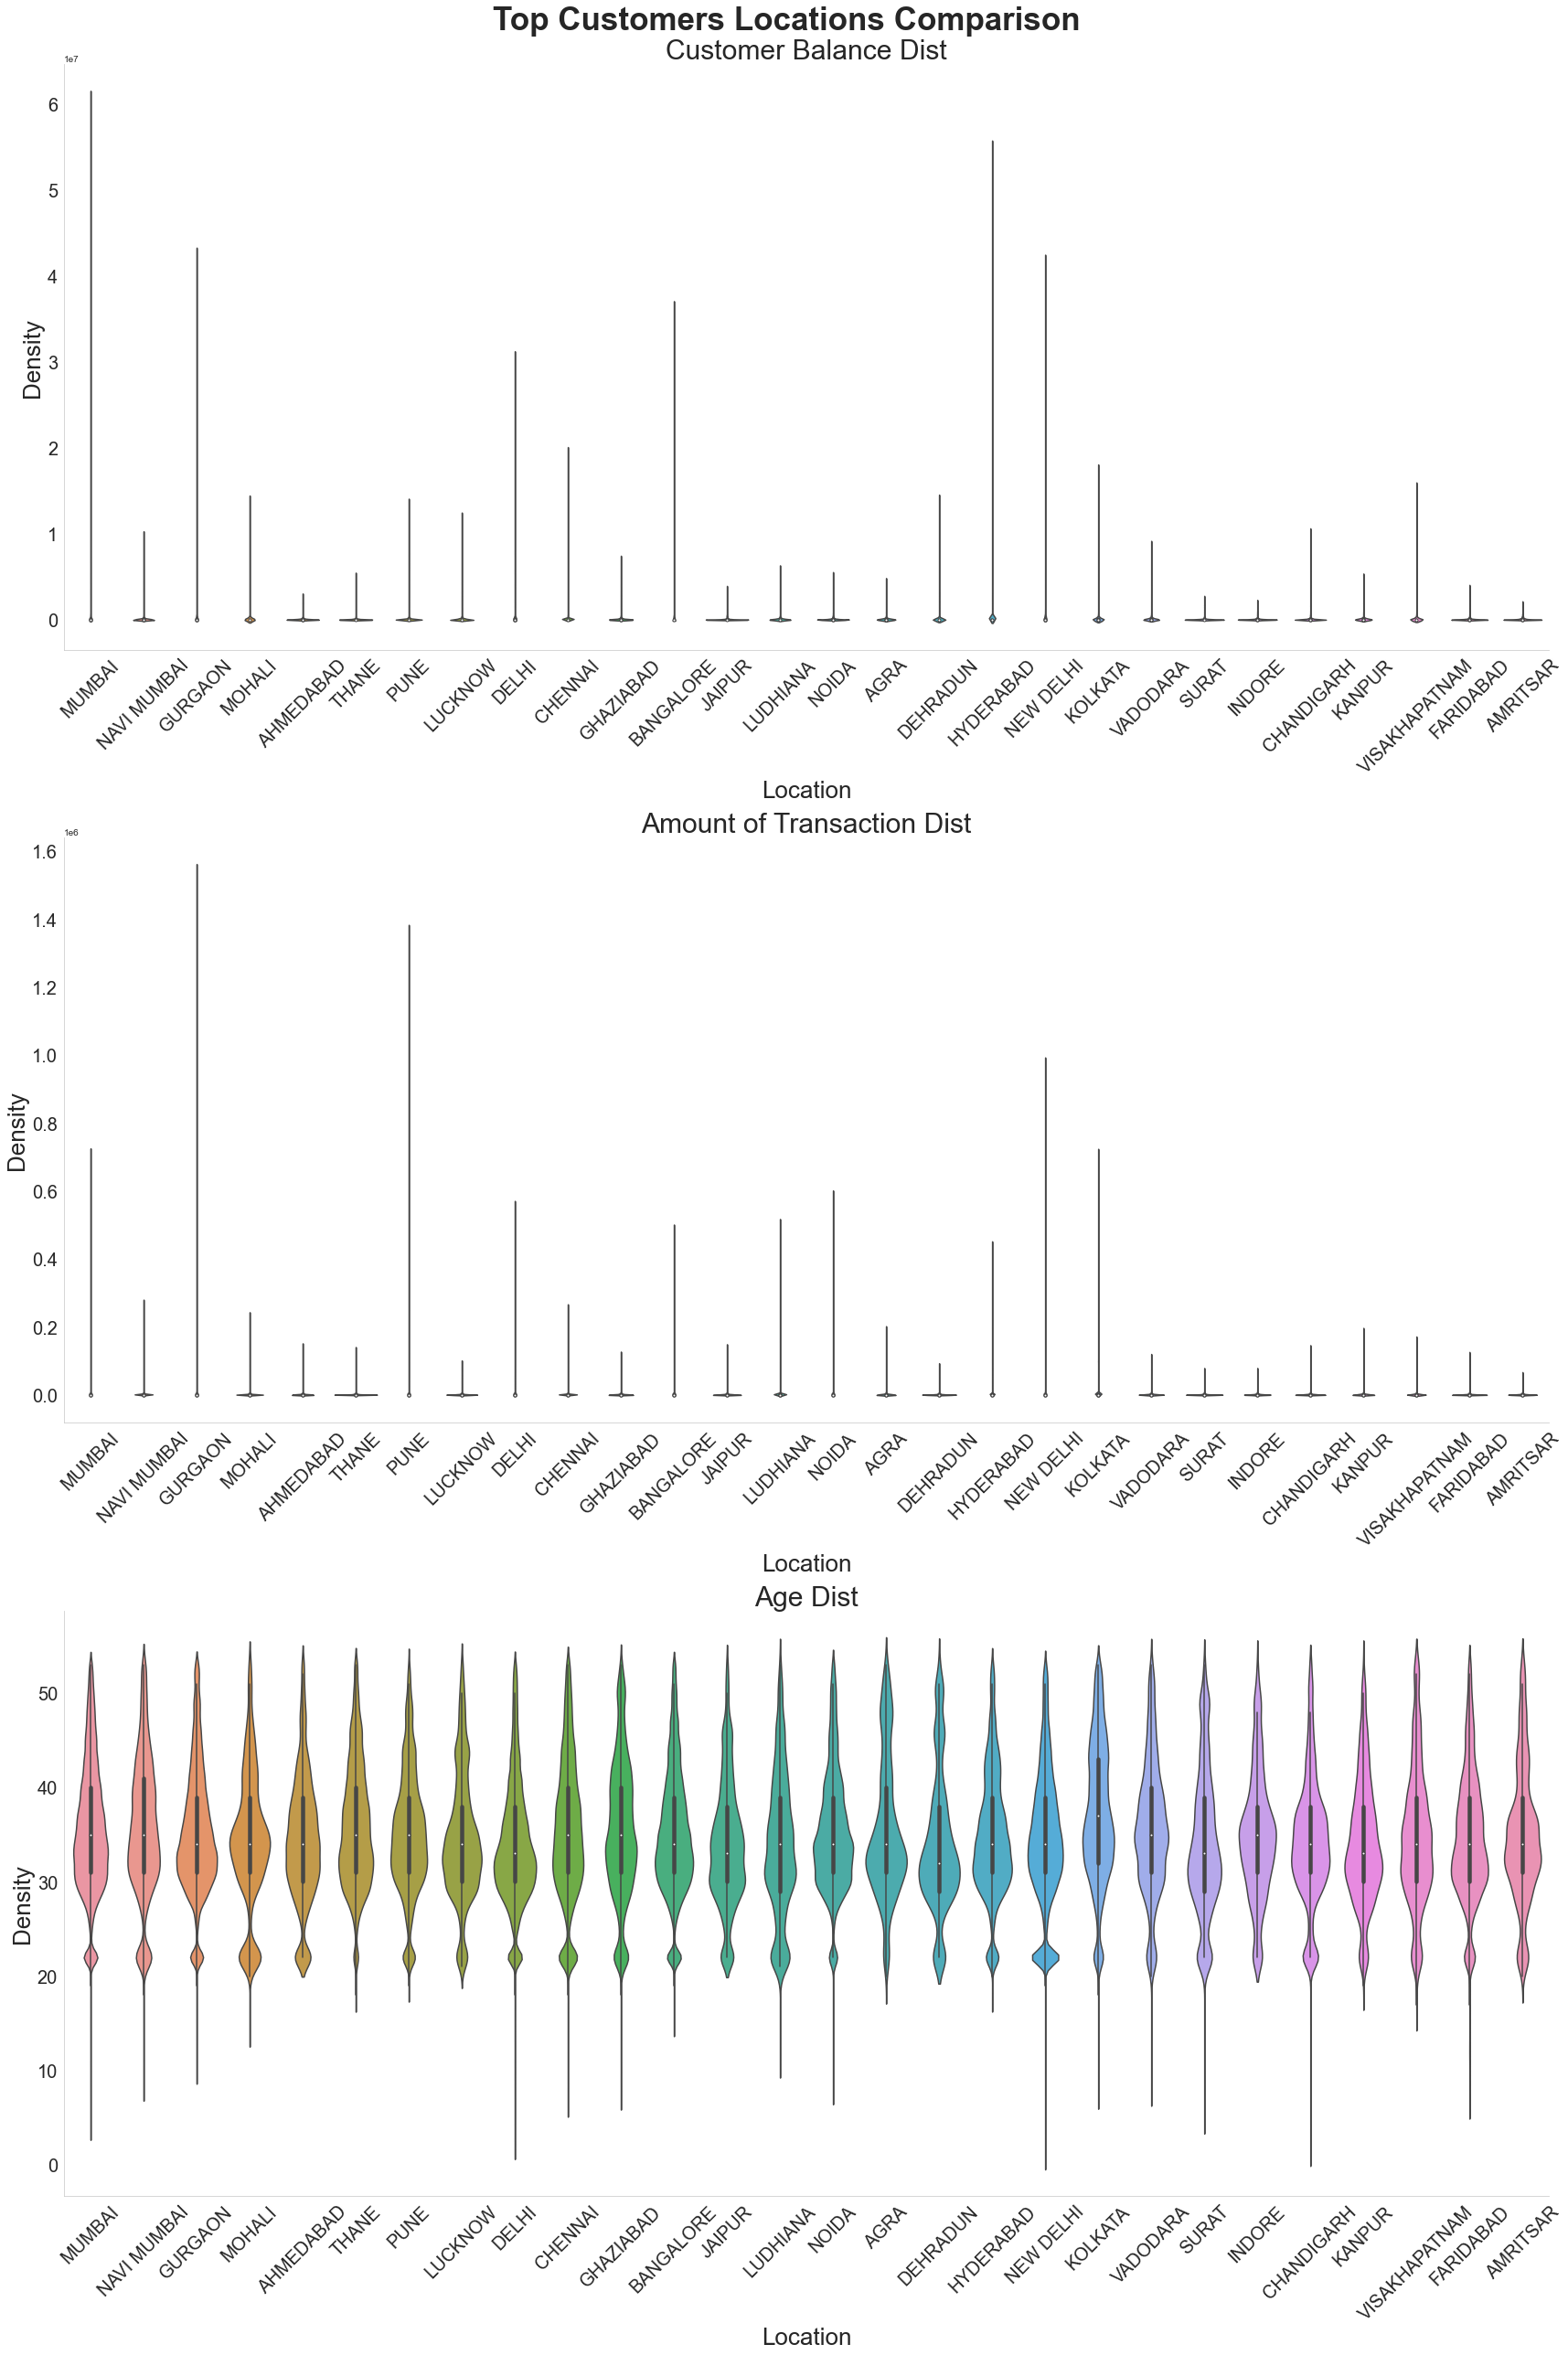

In [107]:
fig, (ax17, ax18, ax19) = plt.subplots(3,1,figsize=(24,36))
fig.suptitle("Top Customers Locations Comparison", fontsize=35,fontweight='bold', verticalalignment="bottom")

# Plot 1
plt.subplot(3,1,1)
ax17 = sns.violinplot(x='CustLocation', y='CustAccountBalance',ax=ax17, data=top_data)
ax17.set_ylabel('Density',fontsize=26,fontweight='normal')    
ax17.set_xlabel('Location',fontsize=26,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax17.spines['right'].set_visible(False)
ax17.spines['top'].set_visible(False)
ax17.set_title('Customer Balance Dist',fontsize=30, fontweight='normal')

# Plot 2
plt.subplot(3,1,2)
ax18 = sns.violinplot(x='CustLocation', y='TransactionAmount (INR)',ax=ax18, data=top_data)
ax18.set_ylabel('Density',fontsize=26,fontweight='normal')    
ax18.set_xlabel('Location',fontsize=26,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax18.spines['right'].set_visible(False)
ax18.spines['top'].set_visible(False)
ax18.set_title('Amount of Transaction Dist',fontsize=30, fontweight='normal')

# Plot 3
plt.subplot(3,1,3)
ax19 = sns.violinplot(x='CustLocation', y='Age',ax=ax19, data=top_data)
ax19.set_ylabel('Density',fontsize=26,fontweight='normal')    
ax19.set_xlabel('Location',fontsize=26,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax19.spines['right'].set_visible(False)
ax19.spines['top'].set_visible(False)
ax19.set_title('Age Dist',fontsize=30, fontweight='normal')

plt.tight_layout()

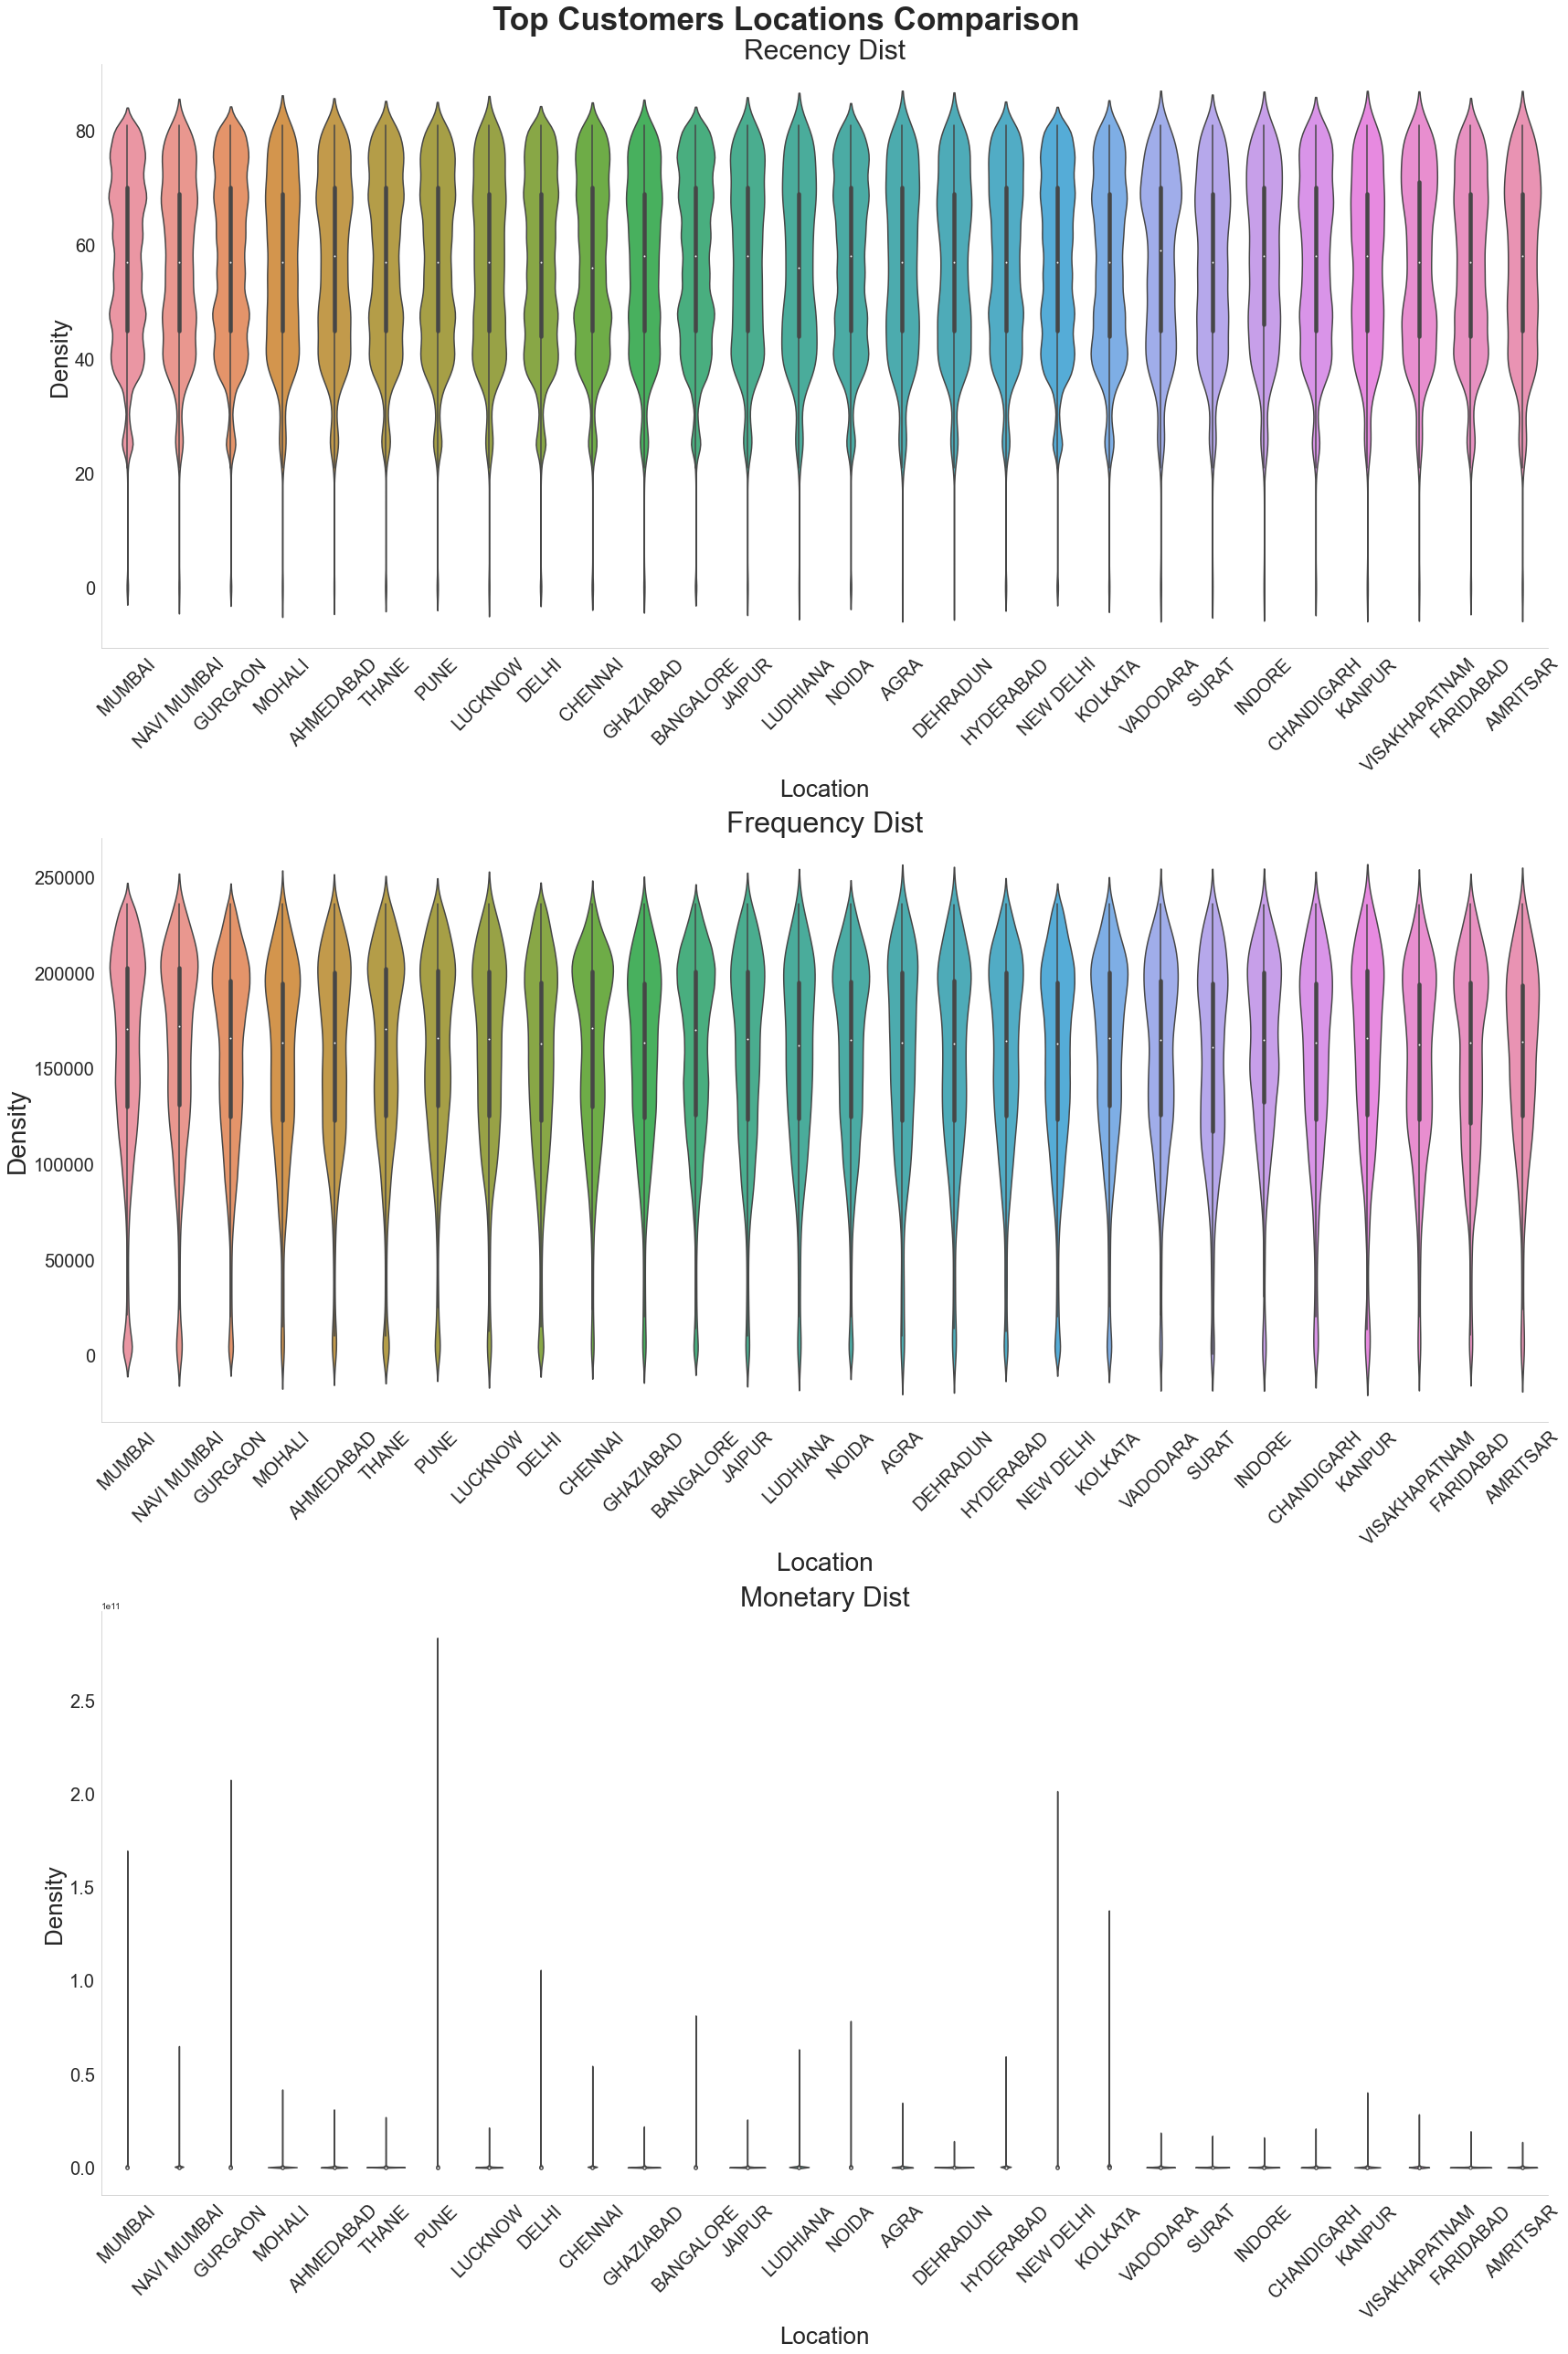

In [110]:
fig, (ax20, ax21, ax22) = plt.subplots(3,1,figsize=(24,36))
fig.suptitle("Top Customers Locations Comparison", fontsize=35,fontweight='bold', verticalalignment="bottom")

# Plot 1
plt.subplot(3,1,1)
ax20 = sns.violinplot(x='CustLocation', y='Recency',ax=ax20, data=top_data)
ax20.set_ylabel('Density',fontsize=26,fontweight='normal')    
ax20.set_xlabel('Location',fontsize=26,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax20.spines['right'].set_visible(False)
ax20.spines['top'].set_visible(False)
ax20.set_title('Recency Dist',fontsize=30, fontweight='normal')

# Plot 2
plt.subplot(3,1,2)
ax21 = sns.violinplot(x='CustLocation', y='Frequency',ax=ax21, data=top_data)
ax21.set_ylabel('Density',fontsize=28,fontweight='normal')    
ax21.set_xlabel('Location',fontsize=28,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax21.spines['right'].set_visible(False)
ax21.spines['top'].set_visible(False)
ax21.set_title('Frequency Dist',fontsize=32, fontweight='normal')

# Plot 3
plt.subplot(3,1,3)
ax22 = sns.violinplot(x='CustLocation', y='Monetary',ax=ax22, data=top_data)
ax22.set_ylabel('Density',fontsize=26,fontweight='normal')    
ax22.set_xlabel('Location',fontsize=26,fontweight='normal') 
plt.xticks( fontsize=20,rotation=45)
plt.yticks( fontsize=20)
ax22.spines['right'].set_visible(False)
ax22.spines['top'].set_visible(False)
ax22.set_title('Monetary Dist',fontsize=30, fontweight='normal')

plt.tight_layout()

### Analytical / Dataset Filtering with Pandasql

### Question 1

 Find customers average age on locations satisfy the following:
 - Top 15 locations in terms of customers balance total
 - Sum Monetary of transactions is greater than the Average of the Monetary Total of top 15 locations
 - Average Recency is greater than or equal to Average of the Average Recency of top 15 top locations  

In [99]:
query4 = """
WITH CTE1 AS
(SELECT CustLocation, Sum_Balance, Avg_age  
FROM (SELECT CustLocation, SUM(CustAccountBalance) Sum_Balance, AVG(Age) Avg_age,
    RANK() OVER(ORDER BY SUM(CustAccountBalance) DESC) Rank
    FROM Data
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC, 4 DESC
) SUBQUERY
WHERE Rank < 16
ORDER BY 3 DESC)

, CTE4 AS
(WITH CTE2 as
(SELECT CustLocation, Sum_Monetary, Avg_Age
FROM (SELECT CustLocation, SUM(Monetary) Sum_Monetary, AVG(Age) Avg_Age,
RANK() OVER(ORDER BY SUM(Monetary) DESC) Rank
FROM Data
GROUP BY 1
ORDER BY 2 DESC, 3 DESC
) SUBQUERY
WHERE Rank < 16)

SELECT CustLocation, SUM(Monetary) Sum_Monetary, AVG(Age) Avg_Age
FROM Data
GROUP BY 1
HAVING SUM(Monetary) >
(SELECT AVG(Sum_Monetary) FROM CTE2)
ORDER BY 3 DESC)

, CTE5 AS
(WITH CTE3 as
(SELECT CustLocation, Avg_Recency
FROM (SELECT CustLocation, AVG(Recency) Avg_Recency,
RANK() OVER(ORDER BY AVG(Recency) DESC) Rank
FROM Data
GROUP BY 1
ORDER BY 2 DESC, 3 DESC
) SUBQUERY
WHERE Rank < 16)

SELECT CustLocation, AVG(Recency) Avg_Recency, AVG(Age) Avg_Age
FROM Data
GROUP BY 1
HAVING AVG(Recency) >=
(SELECT AVG(Avg_Recency) FROM CTE3)
ORDER BY 3 DESC )

SELECT CustLocation, AVG(Age) Avg_Age
FROM Data
GROUP BY 1
HAVING CustLocation IN (SELECT CustLocation FROM CTE1) AND
CustLocation IN (SELECT CustLocation FROM CTE4) OR
CustLocation IN (SELECT CustLocation FROM CTE5)
ORDER BY 2 DESC
"""

sql_run(query4)

CustLocation    Avg_Age
0                            EAST RIFFA  52.000000
1                            IE PALGHAR  51.000000
2          CHUNNABHATTI SIGNAL SION (E)  50.000000
3                    BAER GREATER NOIDA  48.000000
4                    CANACONA SOUTH GOA  43.000000
5           NR UNITY HOSPITAL BANGALORE  42.000000
6               SANTACRUZ (EAST) MUMBAI  41.000000
7                           DELHI CANTT  40.000000
8       ABOVE DR BATRA CLINIC BANGALORE  39.000000
9                            RAIBAREILY  38.000000
10                          TRICHY (DT)  37.000000
11      RELIANCE SUPER MARKET HYDERABAD  37.000000
12                               PANOOR  37.000000
13                       KANDIWALI EAST  37.000000
14                             BAMBOLIA  37.000000
15                    WARD NO 75 NAGPUR  36.000000
16          KODIGHALII RLY STN BANGLORE  36.000000
17                               MUMBAI  35.698409
18                              GURGAON  35.368113
19                            BANGALORE  35.239817
20                                KODUR  35.000000
21                     BYCULLA E MUMBAI  35.000000
22                            NEW DELHI  34.694976
23                                DELHI  34.013758
24                                VYARA  34.000000
25     NGR POWAI MUMBAI SAKINAKA MUMBAI  34.000000
26                        CHIKKAMAGALUR  33.000000
27          BLOCK JAKKASANDRA BANGALORE  33.000000
28                              BHARANG  33.000000
29                       COMPANY MUMBAI  32.000000
30                        BAHULA NASHIK  32.000000
31                             PHENSONG  31.000000
32         ROAD EMP ID P11246 BANGALORE  30.000000
33                               NAMBOL  30.000000
34                   CHEMBUR FCI MUMABI  30.000000
35    RANGAREEDI P AND T CLY RANGAREDDI  28.000000
36          NR E AND D OFFICE KARIMGANJ  27.000000
37                               SAMTRA  26.000000
38                      VODAFONE MUMBAI  22.000000
39              ULHASNAGAR-3 ULHASNAGAR  22.000000
40                TANIYA TOWN THA THANE  22.000000
41  SOUTH INDIA SHOPPING MALL HYDERABAD  22.000000
42                SHREE RESIDENCY SURAT  22.000000
43                        NAGAR BALTANA  22.000000
44                      MANESAR GURGAON  22.000000
45                           HOTEL PUNE  22.000000
46      DIST VALSAD OPP LIC OFFICE VAPI  22.000000
47               ALMOND HOUSE HYDERABAD  22.000000
48        (W) NEAR RAMDEV MANDIR MUMBAI  22.000000

### Question 2

 Find customers Recency and Frequency on locations which satisfy the following:
 - Located in the bottom half in terms Customers Balance Total
 - Average Age of customers is greater than the Average of the Average Age of customers located in bottom half in terms of Balance Total
 - Average of Monetary is less than or equal to Average of the Average Monetary of top 200 cities in Monetary

In [100]:
query6 = """
WITH CTE1 AS
(SELECT CustLocation, Sum_Balance
FROM (SELECT CustLocation, SUM(CustAccountBalance) Sum_Balance,
    RANK() OVER(ORDER BY SUM(CustAccountBalance)) Rank
    FROM Data
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC
) SUBQUERY
WHERE Rank BETWEEN 4000 and 4021)

,CTE4 AS
(WITH CTE2 AS
(SELECT CustLocation, Sum_Balance, Avg_Age
FROM (SELECT CustLocation, SUM(CustAccountBalance) Sum_Balance, AVG(Age) Avg_Age,
    RANK() OVER(ORDER BY SUM(CustAccountBalance)) Rank
    FROM Data
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC, 4 DESC
) SUBQUERY
WHERE Rank BETWEEN 4000 and 4021
ORDER BY 2 DESC, 3 DESC)

SELECT CustLocation, SUM(CustAccountBalance) Sum_Balance, AVG(Age) Avg_Age
FROM Data
GROUP BY 1
HAVING AVG(Age) >
(SELECT AVG(Avg_Age) FROM CTE2) AND
CustLocation IN (SELECT CustLocation FROM CTE2)
ORDER BY 3 DESC)

,CTE5 AS
(WITH CTE3 AS
(SELECT CustLocation, Avg_Monetary
FROM (SELECT CustLocation, AVG(Monetary) Avg_Monetary,
    RANK() OVER(ORDER BY AVG(Monetary) DESC) Rank
    FROM Data
    GROUP BY 1
    ORDER BY 2 DESC, 3 DESC
) SUBQUERY
WHERE Rank <=200
ORDER BY 2 DESC)

SELECT CustLocation, AVG(Monetary) Avg_Monetary
FROM Data
GROUP BY 1
HAVING AVG(Monetary) <=
(SELECT AVG(Monetary) FROM CTE3) 
ORDER BY 2 DESC)

SELECT CustLocation, AVG(Frequency), AVG(Recency)
FROM Data
GROUP BY 1
HAVING CustLocation IN (SELECT CustLocation FROM CTE1) AND
CustLocation IN (SELECT CustLocation FROM CTE4) AND
CustLocation IN (SELECT CustLocation FROM CTE5)
ORDER BY 2 DESC

"""

sql_run(query6)

CustLocation  AVG(Frequency)  AVG(Recency)
0   OPP LAKE CITY MALL THANE WEST THANE   176246.750000     58.375000
1                               HARYANA   170773.500000     75.000000
2                              DELHI-96   168355.000000     69.500000
3             STATE BANK OF MYSORE PUNE   167988.043478     54.043478
4                          SCHOOL HABRA   162670.000000     54.000000
5                    NAGAR EAST CHENNAI   160068.090909     71.090909
6         TO BOWRING HOSPITAL BANGALORE   149262.714286     65.714286
7                               READING   137593.500000     74.000000
8                      MATUNGA E MUMBAI   135774.000000     50.500000
9                       BURAKOTA ALMORA   116801.833333     41.500000
10                               NAROLI   106430.833333     62.666667